In [1]:
from utils import *
from model import *
from models import *
import random
import numpy as np
import torch
import tensorflow as tf
import os

# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set environment seed (optional)
os.environ['PYTHONHASHSEED'] = str(seed)



ticker = "BTC-USD"  # Bitcoin
# or
ticker = "GLD"  # SPDR Gold Shares
# or
ticker = "XLF"  # Financial sector ETF
# or
ticker = "TSLA"  # Tesla, for a high-volatility equity

In [2]:
ticker = "TSLA"
start_date = "1997-01-01"
end_date = "2017-01-01"
df = download_stock_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
df = add_technical_indicators(df, ticker)


Data saved: TSLA_technical_indicators.csv


In [4]:
pop = initialize_population(10)
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')

results = []

for i, chromo in enumerate(pop):
    metrics = evaluate_fitness(chromo, df)
    results.append(metrics)

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)

# Expand chromosome genes into separate columns
chromo_df = pd.DataFrame(results_df['chromosome'].tolist(),
                         columns=['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
                                  'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int'])

# Combine with metrics
final_df = pd.concat([chromo_df, results_df.drop(columns=['chromosome'])], axis=1)

# Reorder columns for clarity
cols_order = ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
              'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int',
              'total_return', 'annualized_return', 'sharpe_ratio',
              'sortino_ratio', 'max_drawdown', 'fitness']

final_df = final_df[cols_order]

# Display as comparison table
print("\n=== Genetic Algorithm Chromosome Performance Comparison ===")
print(final_df.to_string(index=False))

# Save to CSV for further analysis
final_df.to_csv('data/GA_chromosome_metrics.csv', index=False)
print("\nResults saved to GA_chromosome_metrics.csv")


=== Genetic Algorithm Chromosome Performance Comparison ===
 down_buy_val  down_buy_int  down_sell_val  down_sell_int  up_buy_val  up_buy_int  up_sell_val  up_sell_int  total_return  annualized_return  sharpe_ratio  sortino_ratio  max_drawdown  fitness
    27.379938             5      85.954267             12   12.812376           8    83.684482            7      1.127715           0.123018      0.554271       0.449230     -0.425369 0.289203
    25.667238             6      61.042903             11   13.143131           5    79.643577           18      3.381593           0.254851      0.935329       0.826542     -0.406097 0.627563
    12.715422            13      88.330066              5   31.558258          10    84.434879           15      3.359156           0.253862      0.752369       0.937224     -0.458625 0.553528
    14.725497            11      93.502458             15    8.577360          17    63.385073           16      1.415102           0.145094      0.882258       0.5757

In [5]:
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')
genetic_algorithm(df)

Generation 1: Best Fitness = 1.0541
Generation 2: Best Fitness = 1.0541
  No improvement. Stagnation count: 1/10
Generation 3: Best Fitness = 1.1009
Generation 4: Best Fitness = 1.1853
Generation 5: Best Fitness = 1.1853
  No improvement. Stagnation count: 1/10
Generation 6: Best Fitness = 1.1853
  No improvement. Stagnation count: 2/10
Generation 7: Best Fitness = 1.4514
Generation 8: Best Fitness = 1.4514
  No improvement. Stagnation count: 1/10
Generation 9: Best Fitness = 1.4514
  No improvement. Stagnation count: 2/10
Generation 10: Best Fitness = 1.4514
  No improvement. Stagnation count: 3/10
Generation 11: Best Fitness = 1.5112
Generation 12: Best Fitness = 1.5112
  No improvement. Stagnation count: 1/10
Generation 13: Best Fitness = 1.5112
  No improvement. Stagnation count: 2/10
Generation 14: Best Fitness = 1.5112
  No improvement. Stagnation count: 3/10
Generation 15: Best Fitness = 1.5112
  No improvement. Stagnation count: 4/10
Generation 16: Best Fitness = 1.5112
  No im

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from models.mlp_model import MLPClassifier
from utils import create_labeled_dataset

# Custom dataset class
class RSIDataset(Dataset):
    def __init__(self, df):
        self.X = df[['RSI', 'Interval', 'Trend']].values.astype('float32')
        self.y = df['Label'].values.astype('int64')

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Main training function
def train_mlp(df, best_chromosome, epochs=200, batch_size=128, lr=0.001):
    # Prepare dataset
    labeled_df = create_labeled_dataset(df, best_chromosome)
    dataset = RSIDataset(labeled_df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, loss, optimizer
    model = MLPClassifier()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")
            
    os.makedirs("optimized_models", exist_ok=True)
    # Save trained model
    torch.save(model.state_dict(), "optimized_models/trained_mlp.pth")
    print("\nModel saved as trained_mlp.pth")

if __name__ == "__main__":
    # Example usage
    df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')
    
    # Load your GA final results to extract best chromosome
    ga_results = pd.read_csv('data/GA_final_results.csv')
    best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
        ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
         'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
    ].values.tolist()

    train_mlp(df, best_chromosome)


In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from models.mlp_model import MLPClassifier
from utils import create_labeled_dataset, backtest_strategy

# Load data and model
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')
model = MLPClassifier()
model.load_state_dict(torch.load('optimized_models/trained_mlp.pth'))
model.eval()

# Load best chromosome from GA results
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
        'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Prepare dataset
labeled_df = create_labeled_dataset(df, best_chromosome)
X_test = torch.tensor(labeled_df[['RSI', 'Interval', 'Trend']].values.astype('float32'))

# Predict
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(F.softmax(outputs, dim=1), 1)
    predictions = predicted.numpy()

# Backtest
results, portfolio, trade_returns = backtest_strategy(df.iloc[-len(predictions):], predictions)


# Print results
print("\n=== Backtest Performance mlp ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

In [ ]:
from utils import plot_equity_curve

# Example usage inside backtest_strategy or after
plot_equity_curve(portfolio, title="Backtest Equity Curve", save_path="plots/equity_curve.png")


In [6]:
# tune_mlp.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from models.mlp_model import MLPClassifier_dynamic
from utils import create_labeled_dataset

class RSIDataset(Dataset):
    def __init__(self, df):
        self.X = df[['RSI', 'Interval', 'Trend']].values.astype('float32')
        self.y = df['Label'].values.astype('int64')

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

def train_and_evaluate(df, best_chromosome, hidden_sizes, lr, batch_size, epochs=100):
    labeled_df = create_labeled_dataset(df, best_chromosome)
    dataset = RSIDataset(labeled_df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Build dynamic model
    model = MLPClassifier_dynamic(hidden_sizes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

    return total_loss / len(dataloader)

if __name__ == "__main__":
    # Load data
    df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')
    ga_results = pd.read_csv('data/GA_final_results.csv')
    best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
        ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
         'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
    ].values.tolist()

    # Hyperparameter grid
    learning_rates = [0.001, 0.0005, 0.0001]
    batch_sizes = [64, 128, 256]
    hidden_layer_configs = [
        [20, 10, 8, 6, 5],
        [30, 20, 10],
        [40, 20]
    ]

    results = []

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for hidden_sizes in hidden_layer_configs:
                print(f"\nTesting LR={lr}, Batch Size={batch_size}, Hidden Sizes={hidden_sizes}")
                avg_loss = train_and_evaluate(df, best_chromosome, hidden_sizes, lr, batch_size)
                results.append({
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'hidden_sizes': hidden_sizes,
                    'avg_loss': avg_loss
                })

    # Convert results to DataFrame for easy comparison
    results_df = pd.DataFrame(results)
    results_df.sort_values('avg_loss', inplace=True)
    print("\n=== Hyperparameter Tuning Results ===")
    print(results_df)
    results_df.to_csv("optimized_models/mlp_tuning_results.csv", index=False)



Testing LR=0.001, Batch Size=64, Hidden Sizes=[20, 10, 8, 6, 5]
Epoch [1/100], Loss: 1.0544
Epoch [20/100], Loss: 0.2437
Epoch [40/100], Loss: 0.0776
Epoch [60/100], Loss: 0.0599
Epoch [80/100], Loss: 0.0452
Epoch [100/100], Loss: 0.0409

Testing LR=0.001, Batch Size=64, Hidden Sizes=[30, 20, 10]
Epoch [1/100], Loss: 1.4262
Epoch [20/100], Loss: 0.2561
Epoch [40/100], Loss: 0.1050
Epoch [60/100], Loss: 0.0790
Epoch [80/100], Loss: 0.0560
Epoch [100/100], Loss: 0.0433

Testing LR=0.001, Batch Size=64, Hidden Sizes=[40, 20]
Epoch [1/100], Loss: 1.1517
Epoch [20/100], Loss: 0.3399
Epoch [40/100], Loss: 0.1613
Epoch [60/100], Loss: 0.1113
Epoch [80/100], Loss: 0.0829
Epoch [100/100], Loss: 0.0706

Testing LR=0.001, Batch Size=128, Hidden Sizes=[20, 10, 8, 6, 5]
Epoch [1/100], Loss: 1.1170
Epoch [20/100], Loss: 0.4482
Epoch [40/100], Loss: 0.1892
Epoch [60/100], Loss: 0.0929
Epoch [80/100], Loss: 0.0650
Epoch [100/100], Loss: 0.0568

Testing LR=0.001, Batch Size=128, Hidden Sizes=[30, 20, 

Epoch [1/200], Loss: 1.1539
Epoch [20/200], Loss: 0.4689
Epoch [40/200], Loss: 0.3056
Epoch [60/200], Loss: 0.2573
Epoch [80/200], Loss: 0.2306
Epoch [100/200], Loss: 0.2044
Epoch [120/200], Loss: 0.1841
Epoch [140/200], Loss: 0.1605
Epoch [160/200], Loss: 0.1428
Epoch [180/200], Loss: 0.1195
Epoch [200/200], Loss: 0.0952

Model saved as trained_mlp_final.pth

=== Final Backtest Performance ===
total_return: 5.5471
annualized_return: 0.3373
sharpe_ratio: 1.0570
max_drawdown: -0.2785
Plot saved to plots/final_equity_curve.png


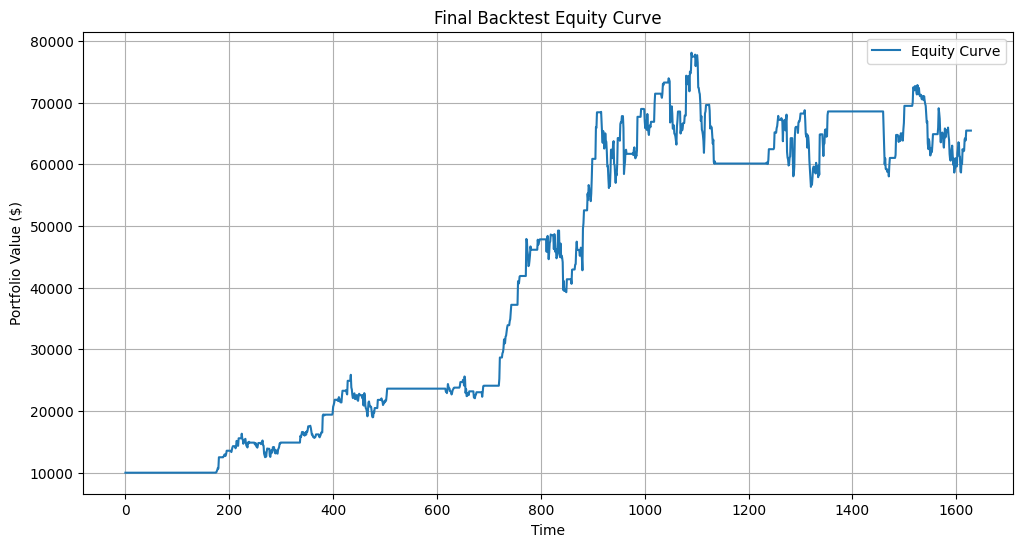

In [7]:
# train_final_mlp.py

import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from models.mlp_model import MLPClassifier_dynamic
from utils import create_labeled_dataset, plot_equity_curve, backtest_strategy

# Custom dataset class
class RSIDataset(Dataset):
    def __init__(self, df):
        self.X = df[['RSI', 'Interval', 'Trend']].values.astype('float32')
        self.y = df['Label'].values.astype('int64')

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

if __name__ == "__main__":
    # Load data
    df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')
    ga_results = pd.read_csv('data/GA_final_results.csv')
    best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
    best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
        ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
         'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
    ].values.tolist()

    # Prepare dataset
    labeled_df = create_labeled_dataset(df, best_chromosome)    
    batch_size_val = pd.to_numeric(best_params.loc[0, 'batch_size'], errors='coerce')
    if isinstance(batch_size_val, complex):
        batch_size_val = batch_size_val.real
    if pd.isnull(batch_size_val):
        raise ValueError("batch_size is not a valid number")
    batch_size = int(batch_size_val)

    lr_val = pd.to_numeric(best_params.loc[0, 'learning_rate'], errors='coerce')
    if isinstance(lr_val, complex):
        lr_val = lr_val.real
    if pd.isnull(lr_val):
        raise ValueError("learning_rate is not a valid number")
    lr = float(lr_val)

    hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
    hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
    dataset = RSIDataset(labeled_df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Build final optimal model
    model = MLPClassifier_dynamic(hidden_sizes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    epochs = 200
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

    # Save trained model
    torch.save(model.state_dict(), "optimized_models/trained_mlp_final.pth")
    print("\nModel saved as trained_mlp_final.pth")

    # Evaluate model
    model.eval()
    X_test = torch.tensor(labeled_df[['RSI', 'Interval', 'Trend']].values.astype('float32'))
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(nn.functional.softmax(outputs, dim=1), 1)
        predictions = predicted.numpy()

    # Backtest using predictions
    results, portfolio, trade_returns = backtest_strategy(labeled_df, predictions)

    # Print results
    print("\n=== Final Backtest Performance ===")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    # Plot equity curve
    plot_equity_curve(portfolio, title="Final Backtest Equity Curve", save_path="plots/final_equity_curve.png")


In [ ]:
from utils import plot_confusion_matrix

# True labels from labeled_df
y_true = labeled_df['Label'].values

# Your model predictions
y_pred = predictions

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=["Hold", "Buy", "Sell"], title="MLP Prediction Confusion Matrix", save_path="plots/mlp_confusion_matrix.png")


In [ ]:
results, portfolio, trade_returns = backtest_strategy(labeled_df, predictions)

# Calculate streaks
from utils import calculate_max_consecutive_streaks
max_wins, max_losses = calculate_max_consecutive_streaks(trade_returns)
print(f"Max consecutive wins: {max_wins}, Max consecutive losses: {max_losses}")


In [ ]:
from utils import plot_prediction_signals

trade_pnls, total_pnl = plot_prediction_signals(labeled_df, predictions, title="MLP Prediction Signals", save_path="plots/mlp_prediction_signals.png")
print(f"Total strategy PnL: {total_pnl:.2%}")

In [ ]:
from utils import calculate_max_consecutive_streaks

# Assuming you have a list of trade returns:
trade_returns = []  # populate with individual trade PnLs

# Example: If you store trade PnLs in backtest_strategy, return them as well
max_wins, max_losses = calculate_max_consecutive_streaks(trade_returns)
print(f"Max consecutive wins: {max_wins}, Max consecutive losses: {max_losses}")



=== Out-of-Sample Backtest Performance ===
total_return: -0.0406
annualized_return: -0.0313
sharpe_ratio: -0.0044
max_drawdown: -0.1947
Prediction signal plot saved to plots/oos_prediction_signals.png


([np.float64(-0.12625445110133934),
  np.float64(0.08796883616275075),
  np.float64(0.05719375281508688),
  np.float64(-0.10996698464880235),
  np.float64(0.061107066691588684),
  np.float64(0.0037478758745772595),
  np.float64(0.06879889923506992),
  np.float64(0.04585032619878972),
  np.float64(-0.10699536982214664),
  np.float64(0.008918779237013511)],
 np.float64(-0.009631269357411595))

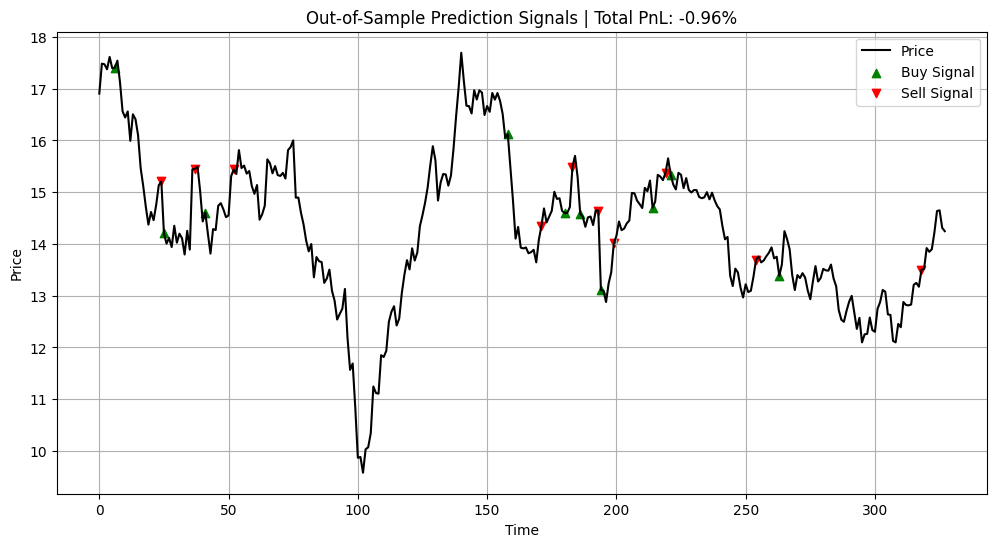

In [8]:
# test_out_of_sample.py

import torch
import pandas as pd
from models.mlp_model import MLPClassifier
from utils import create_labeled_dataset



# Load full dataset
df_full = pd.read_csv(f'data/{ticker}_technical_indicators.csv')
best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")

# Define out-of-sample period (e.g. last 20%)
split_idx = int(len(df_full) * 0.8)
df_train = df_full.iloc[:split_idx]
df_test = df_full.iloc[split_idx:]

# Load best chromosome from GA results
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
        'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Prepare test dataset
labeled_test_df = create_labeled_dataset(df_test, best_chromosome)
X_test = torch.tensor(labeled_test_df[['RSI', 'Interval', 'Trend']].values.astype('float32'))

# Load trained model
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model = MLPClassifier_dynamic(hidden_sizes)
model.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
    predictions = predicted.numpy()

# Backtest on out-of-sample
results, portfolio, trade_returns = backtest_strategy(labeled_test_df, predictions)

# Print out-of-sample performance
print("\n=== Out-of-Sample Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot predictions and signals
plot_prediction_signals(labeled_test_df, predictions, title="Out-of-Sample Prediction Signals", save_path="plots/oos_prediction_signals.png")


In [ ]:
# test_true_out_of_sample.py

import torch
import pandas as pd
from datetime import datetime
from utils import download_stock_data, calculate_RSI, calculate_SMA
from models.mlp_model import MLPClassifier_dynamic
from utils import create_labeled_dataset

# Define out-of-sample period
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Download new out-of-sample data
ticker = "SPY"
df_oos = download_stock_data(ticker, start_date, end_date)
if df_oos is None or df_oos.empty:
    print("No data downloaded for out-of-sample period.")
    exit()

# Calculate indicators
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome from GA results
ga_results = pd.read_csv('data/GA_final_results.csv')
best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
        'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Prepare labeled test dataset
labeled_oos_df = create_labeled_dataset(df_oos, best_chromosome)
X_test = torch.tensor(labeled_oos_df[['RSI', 'Interval', 'Trend']].values.astype('float32'))

# Load trained model
best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model = MLPClassifier_dynamic(hidden_sizes)
model.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
    predictions = predicted.numpy()

# Backtest on true out-of-sample data
results, portfolio, trade_returns = backtest_strategy(labeled_oos_df, predictions)

# Print performance results
print("\n=== True Out-of-Sample Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot prediction signals with positions and PnL
plot_prediction_signals(labeled_oos_df, predictions, title="True OOS Prediction Signals", save_path="plots/true_oos_prediction_signals.png")


In [9]:
# cnn_tuning_and_retraining.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from models.cnn_model import CNNClassifier, RollingWindowDataset
from utils import create_labeled_dataset, download_stock_data, calculate_RSI, calculate_SMA
import itertools

# === Load data ===

ticker = "SPY"
start_date = "1997-01-01"
end_date = "2017-01-01"

df = download_stock_data(ticker, start_date, end_date)
df = calculate_RSI(df)
df = calculate_SMA(df)
df['Trend'] = (df['SMA_50'] > df['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

df_labeled = create_labeled_dataset(df, best_chromosome)

# === Define parameter grid ===

kernel_sizes = [2, 3, 5]
hidden_channels = [8, 16, 32]
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
window_size = 10
epochs = 50

results = []

# === Grid search ===

for ks, hc, lr, bs in itertools.product(kernel_sizes, hidden_channels, learning_rates, batch_sizes):
    print(f"Testing Kernel={ks}, Hidden Channels={hc}, LR={lr}, Batch Size={bs}")

    dataset = RollingWindowDataset(df_labeled, window_size)
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

    model = CNNClassifier(input_channels=3, window_size=window_size, kernel_size=ks, hidden_channels=hc)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

    # Record final average loss
    avg_loss = total_loss / len(dataloader)
    results.append({
        'kernel_size': ks,
        'hidden_channels': hc,
        'learning_rate': lr,
        'batch_size': bs,
        'avg_loss': avg_loss
    })

# === Save tuning results ===

results_df = pd.DataFrame(results)
results_df.sort_values('avg_loss', inplace=True)

print("\n=== CNN Tuning Results ===")
print(results_df.to_string(index=False))

results_df.to_csv('data/cnn_tuning_results.csv', index=False)

# === Step 2: Retrain final CNN with best configuration ===

best = results_df.iloc[0]
print(f"\nRetraining final CNN with best config: Kernel={best['kernel_size']}, Hidden Channels={best['hidden_channels']}, LR={best['learning_rate']}, Batch Size={best['batch_size']}")

dataset = RollingWindowDataset(df_labeled, window_size)
dataloader = DataLoader(dataset, batch_size=int(best['batch_size']), shuffle=True)

final_model = CNNClassifier(input_channels=3, window_size=window_size, kernel_size=int(best['kernel_size']), hidden_channels=int(best['hidden_channels']))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best['learning_rate'])

final_epochs = 100

for epoch in range(final_epochs):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"[Final Retrain] Epoch [{epoch+1}/{final_epochs}], Loss: {total_loss/len(dataloader):.4f}")

# === Save final retrained model ===

torch.save(final_model.state_dict(), 'optimized_models/trained_cnn_best_tuned.pth')
print("\nFinal tuned CNN model saved as optimized_models/trained_cnn_best_tuned.pth")




[*********************100%***********************]  1 of 1 completed


Testing Kernel=2, Hidden Channels=8, LR=0.001, Batch Size=32
Epoch [10/50], Loss: 0.7136
Epoch [20/50], Loss: 0.6950
Epoch [30/50], Loss: 0.6883
Epoch [40/50], Loss: 0.6777
Epoch [50/50], Loss: 0.6639
Testing Kernel=2, Hidden Channels=8, LR=0.001, Batch Size=64
Epoch [10/50], Loss: 0.7054
Epoch [20/50], Loss: 0.6859
Epoch [30/50], Loss: 0.6747
Epoch [40/50], Loss: 0.6722
Epoch [50/50], Loss: 0.6633
Testing Kernel=2, Hidden Channels=8, LR=0.0005, Batch Size=32
Epoch [10/50], Loss: 0.7141
Epoch [20/50], Loss: 0.6944
Epoch [30/50], Loss: 0.6827
Epoch [40/50], Loss: 0.6747
Epoch [50/50], Loss: 0.6681
Testing Kernel=2, Hidden Channels=8, LR=0.0005, Batch Size=64
Epoch [10/50], Loss: 0.7284
Epoch [20/50], Loss: 0.7136
Epoch [30/50], Loss: 0.6986
Epoch [40/50], Loss: 0.6920
Epoch [50/50], Loss: 0.6897
Testing Kernel=2, Hidden Channels=16, LR=0.001, Batch Size=32
Epoch [10/50], Loss: 0.7006
Epoch [20/50], Loss: 0.6783
Epoch [30/50], Loss: 0.6633
Epoch [40/50], Loss: 0.6439
Epoch [50/50], Loss:

In [10]:
# lstm_tuning_and_retraining.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from models.lstm_model import LSTMClassifier, RollingWindowDataset
from utils import create_labeled_dataset, download_stock_data, calculate_RSI, calculate_SMA
import itertools

# === Load data ===

ticker = "SPY"
start_date = "1997-01-01"
end_date = "2017-01-01"

df = download_stock_data(ticker, start_date, end_date)
df = calculate_RSI(df)
df = calculate_SMA(df)
df['Trend'] = (df['SMA_50'] > df['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

df_labeled = create_labeled_dataset(df, best_chromosome)

# === Define parameter grid ===

hidden_sizes = [16, 32, 64]
num_layers_list = [1, 2]
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
window_size = 10
epochs = 50

results = []

# === Grid search ===

for hs, nl, lr, bs in itertools.product(hidden_sizes, num_layers_list, learning_rates, batch_sizes):
    print(f"Testing Hidden Size={hs}, Num Layers={nl}, LR={lr}, Batch Size={bs}")

    dataset = RollingWindowDataset(df_labeled, window_size)
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

    model = LSTMClassifier(input_size=3, hidden_size=hs, num_layers=nl)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

    # Record final average loss
    avg_loss = total_loss / len(dataloader)
    results.append({
        'hidden_size': hs,
        'num_layers': nl,
        'learning_rate': lr,
        'batch_size': bs,
        'avg_loss': avg_loss
    })

# === Save tuning results ===

results_df = pd.DataFrame(results)
results_df.sort_values('avg_loss', inplace=True)

print("\n=== LSTM Tuning Results ===")
print(results_df.to_string(index=False))

results_df.to_csv('data/lstm_tuning_results.csv', index=False)

# === Step 2: Retrain final LSTM with best configuration ===

best = results_df.iloc[0]
print(f"\nRetraining final LSTM with best config: Hidden Size={best['hidden_size']}, Num Layers={best['num_layers']}, LR={best['learning_rate']}, Batch Size={best['batch_size']}")

dataset = RollingWindowDataset(df_labeled, window_size)
dataloader = DataLoader(dataset, batch_size=int(best['batch_size']), shuffle=True)

final_model = LSTMClassifier(input_size=3, hidden_size=int(best['hidden_size']), num_layers=int(best['num_layers']))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best['learning_rate'])

final_epochs = 100

for epoch in range(final_epochs):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"[Final Retrain] Epoch [{epoch+1}/{final_epochs}], Loss: {total_loss/len(dataloader):.4f}")

# === Save final retrained model ===

torch.save(final_model.state_dict(), 'optimized_models/trained_lstm_best_tuned.pth')
print("\nFinal tuned LSTM model saved as optimized_models/trained_lstm_best_tuned.pth")


[*********************100%***********************]  1 of 1 completed


Testing Hidden Size=16, Num Layers=1, LR=0.001, Batch Size=32
Epoch [10/50], Loss: 0.5783
Epoch [20/50], Loss: 0.5679
Epoch [30/50], Loss: 0.5622
Epoch [40/50], Loss: 0.5619
Epoch [50/50], Loss: 0.5571
Testing Hidden Size=16, Num Layers=1, LR=0.001, Batch Size=64
Epoch [10/50], Loss: 0.5981
Epoch [20/50], Loss: 0.5757
Epoch [30/50], Loss: 0.5683
Epoch [40/50], Loss: 0.5633
Epoch [50/50], Loss: 0.5646
Testing Hidden Size=16, Num Layers=1, LR=0.0005, Batch Size=32
Epoch [10/50], Loss: 0.5990
Epoch [20/50], Loss: 0.5781
Epoch [30/50], Loss: 0.5711
Epoch [40/50], Loss: 0.5673
Epoch [50/50], Loss: 0.5641
Testing Hidden Size=16, Num Layers=1, LR=0.0005, Batch Size=64
Epoch [10/50], Loss: 0.6267
Epoch [20/50], Loss: 0.5861
Epoch [30/50], Loss: 0.5740
Epoch [40/50], Loss: 0.5697
Epoch [50/50], Loss: 0.5646
Testing Hidden Size=16, Num Layers=2, LR=0.001, Batch Size=32
Epoch [10/50], Loss: 0.5719
Epoch [20/50], Loss: 0.5577
Epoch [30/50], Loss: 0.5491
Epoch [40/50], Loss: 0.5422
Epoch [50/50], L

[*********************100%***********************]  1 of 1 completed


Loaded CNN best parameters from CSV:
Kernel size: 5, Hidden channels: 16, LR: 0.001, Batch size: 32

=== CNN Prediction Counts ===
(array([0, 1, 2]), array([739, 682, 691]))

=== CNN Backtest Performance ===
total_return: 0.1461
annualized_return: 0.0164
sharpe_ratio: 0.4659
max_drawdown: -0.0866
Prediction signal plot saved to plots/cnn_tuned_prediction_signals.png
Confusion matrix saved to plots/cnn_tuned_confusion_matrix.png
Loaded LSTM best parameters from CSV:
Hidden size: 64, Num layers: 2, LR: 0.001, Batch size: 32

=== LSTM Prediction Counts ===
(array([0, 1, 2]), array([702, 720, 690]))

=== LSTM Backtest Performance ===
total_return: 0.1639
annualized_return: 0.0183
sharpe_ratio: 0.5241
max_drawdown: -0.0736
Prediction signal plot saved to plots/lstm_tuned_prediction_signals.png
Confusion matrix saved to plots/lstm_tuned_confusion_matrix.png


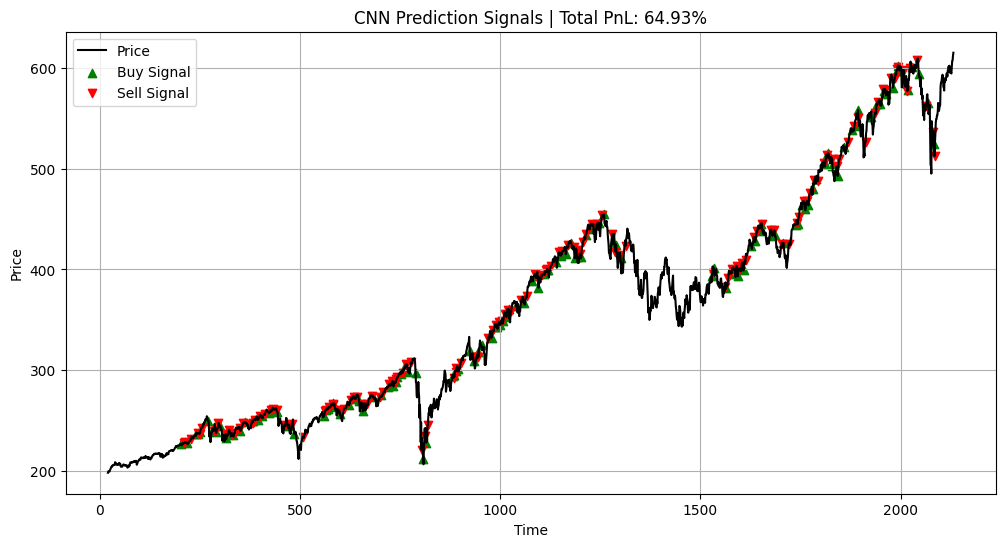

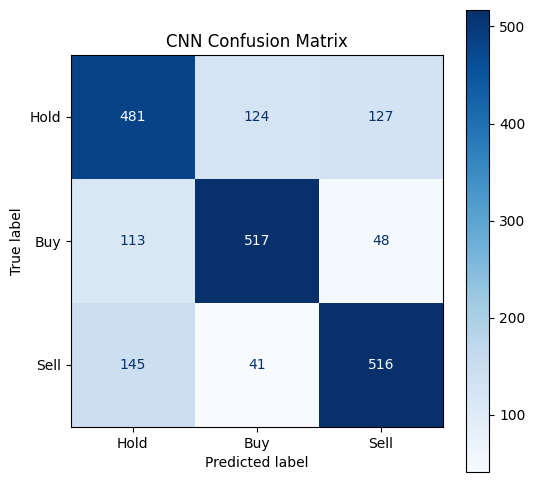

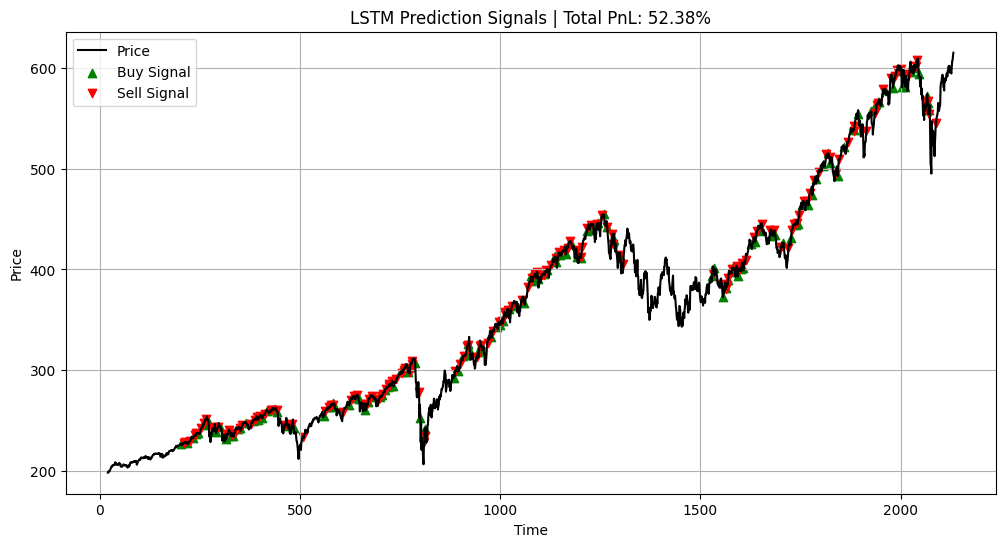

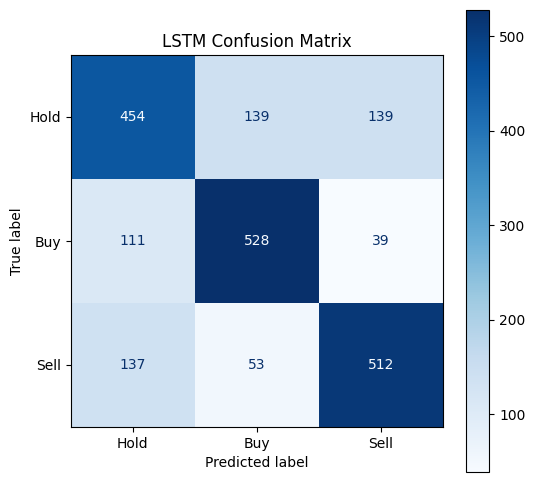

In [11]:
import torch
import pandas as pd
from datetime import datetime
import numpy as np
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, plot_prediction_signals, download_stock_data, calculate_RSI, calculate_SMA, plot_confusion_matrix

# === Load OOS data ===

ticker = "SPY"
start_date = "2017-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

df_labeled = create_labeled_dataset(df_oos, best_chromosome)
window_size = 10

# === CNN evaluation ===
# Load CNN best parameters directly from CSV
cnn_results = pd.read_csv('data/cnn_tuning_results.csv')
best_cnn = cnn_results.iloc[0]

best_kernel = int(best_cnn['kernel_size'])
best_hidden_channels = int(best_cnn['hidden_channels'])
best_learning_rate = float(best_cnn['learning_rate'])
best_batch_size = int(best_cnn['batch_size'])

print("Loaded CNN best parameters from CSV:")
print(f"Kernel size: {best_kernel}, Hidden channels: {best_hidden_channels}, LR: {best_learning_rate}, Batch size: {best_batch_size}")


cnn_dataset = CNNRollingDataset(df_labeled, window_size)
X_cnn = torch.stack([sample[0] for sample in cnn_dataset])
model_cnn = CNNClassifier(input_channels=3, window_size=window_size, kernel_size=best_kernel, hidden_channels=best_hidden_channels)  # replace with best tuned params
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model_cnn.eval()

with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    probs_cnn = torch.nn.functional.softmax(outputs_cnn, dim=1).numpy()
    preds_cnn = np.argmax(probs_cnn, axis=1)

print("\n=== CNN Prediction Counts ===")
print(np.unique(preds_cnn, return_counts=True))

# CNN backtest
df_eval = df_labeled.iloc[-len(preds_cnn):]
results_cnn, portfolio_cnn, trade_returns_cnn = backtest_strategy_with_position_stoploss(
    df_eval, preds_cnn,
    position_size=0.25, stop_loss=0.03, take_profit=0.10
)

print("\n=== CNN Backtest Performance ===")
for k, v in results_cnn.items():
    print(f"{k}: {v:.4f}")

plot_prediction_signals(df_eval, preds_cnn, title="CNN Prediction Signals", save_path="plots/cnn_tuned_prediction_signals.png")

plot_confusion_matrix(
    df_eval['Label'], preds_cnn,
    classes=["Hold", "Buy", "Sell"],
    title="CNN Confusion Matrix",
    save_path="plots/cnn_tuned_confusion_matrix.png"
)

# === LSTM evaluation ===

lstm_results = pd.read_csv('data/lstm_tuning_results.csv')
best_lstm = lstm_results.iloc[0]

best_hidden_size = int(best_lstm['hidden_size'])
best_num_layers = int(best_lstm['num_layers'])
best_learning_rate = float(best_lstm['learning_rate'])
best_batch_size = int(best_lstm['batch_size'])

print("Loaded LSTM best parameters from CSV:")
print(f"Hidden size: {best_hidden_size}, Num layers: {best_num_layers}, LR: {best_learning_rate}, Batch size: {best_batch_size}")


lstm_dataset = LSTMRollingDataset(df_labeled, window_size)
X_lstm = torch.stack([sample[0] for sample in lstm_dataset])
model_lstm = LSTMClassifier(input_size=3, hidden_size=best_hidden_size, num_layers=best_num_layers)  # replace with best tuned params
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()

with torch.no_grad():
    outputs_lstm = model_lstm(X_lstm)
    probs_lstm = torch.nn.functional.softmax(outputs_lstm, dim=1).numpy()
    preds_lstm = np.argmax(probs_lstm, axis=1)

print("\n=== LSTM Prediction Counts ===")
print(np.unique(preds_lstm, return_counts=True))

# LSTM backtest
df_eval = df_labeled.iloc[-len(preds_lstm):]
results_lstm, portfolio_lstm, trade_returns_lstm = backtest_strategy_with_position_stoploss(
    df_eval, preds_lstm,
    position_size=0.25, stop_loss=0.03, take_profit=0.10
)

print("\n=== LSTM Backtest Performance ===")
for k, v in results_lstm.items():
    print(f"{k}: {v:.4f}")

plot_prediction_signals(df_eval, preds_lstm, title="LSTM Prediction Signals", save_path="plots/lstm_tuned_prediction_signals.png")

plot_confusion_matrix(
    df_eval['Label'], preds_lstm,
    classes=["Hold", "Buy", "Sell"],
    title="LSTM Confusion Matrix",
    save_path="plots/lstm_tuned_confusion_matrix.png"
)


In [ ]:
# test_cnn.py

import torch
import pandas as pd
from models.cnn_model import CNNClassifier, RollingWindowDataset
from utils import create_labeled_dataset, plot_prediction_signals, backtest_strategy

# Load data
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
from utils import create_labeled_dataset
df_labeled = create_labeled_dataset(df, best_chromosome)

# Prepare dataset
window_size = 10
dataset = RollingWindowDataset(df_labeled, window_size)
X_test = torch.stack([sample[0] for sample in dataset])
y_true = [sample[1].item() for sample in dataset]

# Load trained model
model = CNNClassifier(input_channels=3, window_size=window_size)
model.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
    predictions = predicted.numpy()

# Backtest
results, portfolio, trade_returns = backtest_strategy(df_labeled.iloc[window_size:], predictions)

# Print results
print("\n=== CNN Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot signals
plot_prediction_signals(df_labeled.iloc[window_size:], predictions, title="CNN Prediction Signals", save_path="plots/cnn_prediction_signals.png")


In [ ]:
# test_lstm.py

import torch
import pandas as pd
from models.lstm_model import LSTMClassifier, RollingWindowDataset
from utils import create_labeled_dataset, plot_prediction_signals, backtest_strategy

# Load data and prepare labeled dataset (similar to CNN)

# Prepare dataset
window_size = 10
dataset = RollingWindowDataset(df_labeled, window_size)
X_test = torch.stack([sample[0] for sample in dataset])
y_true = [sample[1].item() for sample in dataset]

# Load trained model
model = LSTMClassifier(input_size=3)
model.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
    predictions = predicted.numpy()

# Backtest
results, portfolio, trade_returns = backtest_strategy(df_labeled.iloc[window_size:], predictions)

# Print results
print("\n=== LSTM Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot signals
plot_prediction_signals(df_labeled.iloc[window_size:], predictions, title="LSTM Prediction Signals", save_path="plots/lstm_prediction_signals.png")


[*********************100%***********************]  1 of 1 completed



=== CNN Out-of-Sample Evaluation ===

=== CNN OOS Backtest Performance ===
total_return: 0.7682
annualized_return: 0.0711
sharpe_ratio: 0.5366
max_drawdown: -0.2747
Prediction signal plot saved to plots/cnn_oos_signals.png

=== LSTM Out-of-Sample Evaluation ===

=== LSTM OOS Backtest Performance ===
total_return: 0.6498
annualized_return: 0.0622
sharpe_ratio: 0.4873
max_drawdown: -0.2610
Prediction signal plot saved to plots/lstm_oos_signals.png


([np.float64(0.012946547023734045),
  np.float64(0.009640448846153055),
  np.float64(0.013640479867167196),
  np.float64(0.006341330949335531),
  np.float64(0.022092862005577595),
  np.float64(0.007834979575279013),
  np.float64(0.010270806802443924),
  np.float64(-0.030983936846805036),
  np.float64(0.01490336983676193),
  np.float64(0.01865644609418053),
  np.float64(-0.0301677381525768),
  np.float64(0.041082546597482124),
  np.float64(0.005817844397435638),
  np.float64(0.014133875647551097),
  np.float64(0.005417817359682342),
  np.float64(0.010839599979037258),
  np.float64(-0.004121796510611672),
  np.float64(0.002255242051237308),
  np.float64(0.013085929703214986),
  np.float64(0.016752835069639895),
  np.float64(0.014427510753941138),
  np.float64(0.001997645476937711),
  np.float64(0.0010654583035142897),
  np.float64(-0.004300241221654237),
  np.float64(-0.050135555996541445),
  np.float64(0.0070572874534076575),
  np.float64(-0.03464165474026006),
  np.float64(0.0187382426

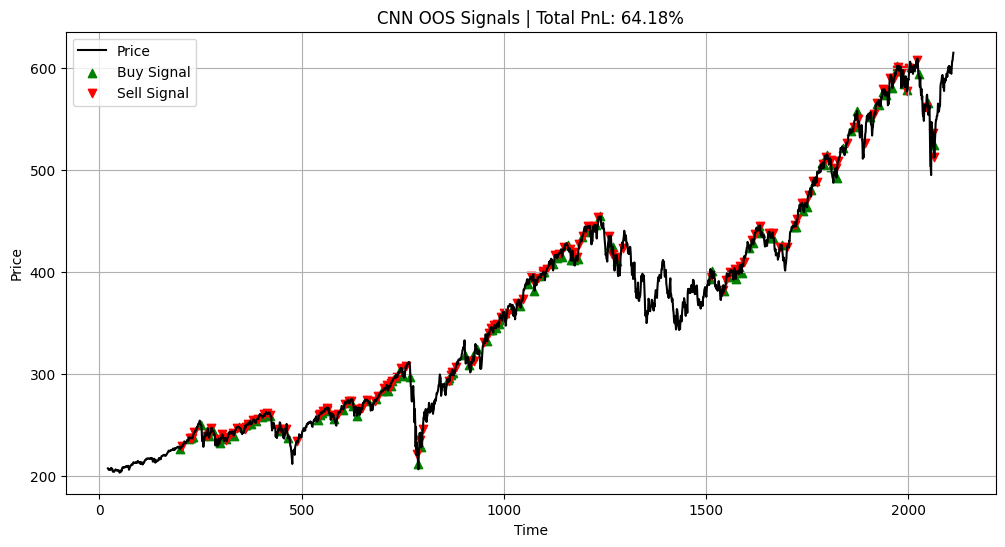

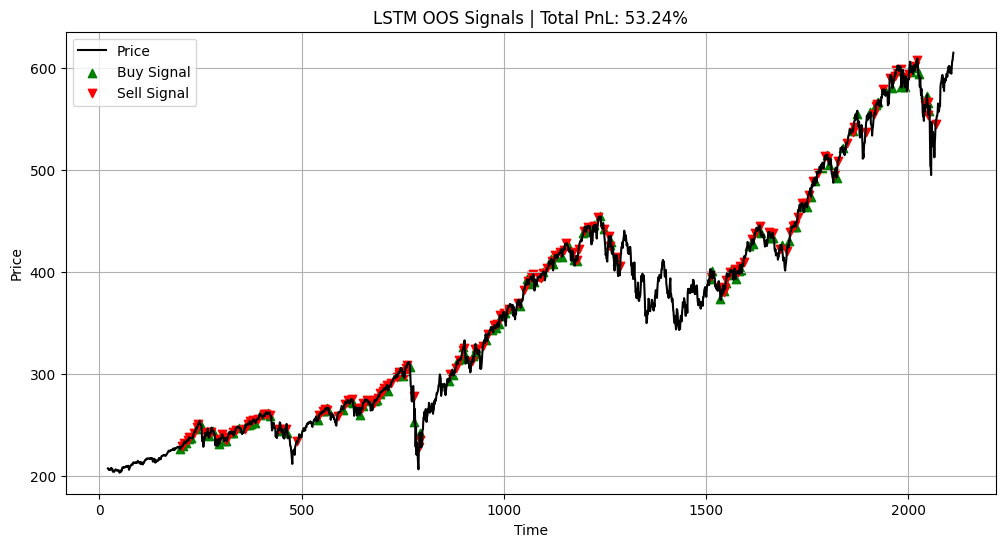

In [13]:
# test_cnn_lstm_oos.py

import torch
import pandas as pd
from datetime import datetime
from utils import download_stock_data, calculate_RSI, calculate_SMA, create_labeled_dataset, backtest_strategy, plot_prediction_signals
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset

# Define out-of-sample period
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

# Download out-of-sample data
df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome from GA results
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df_oos, best_chromosome)

# Define window size
window_size = 10

# CNN evaluation
print("\n=== CNN Out-of-Sample Evaluation ===")
cnn_results = pd.read_csv('data/cnn_tuning_results.csv')
best_cnn = cnn_results.iloc[0]
best_kernel = int(best_cnn['kernel_size'])
best_hidden_channels = int(best_cnn['hidden_channels'])

cnn_dataset = CNNRollingDataset(df_labeled, window_size)
X_cnn = torch.stack([sample[0] for sample in cnn_dataset])
model_cnn = CNNClassifier(
    input_channels=3,
    window_size=window_size,
    kernel_size=best_kernel,
    hidden_channels=best_hidden_channels
)
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model_cnn.eval()

with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    _, preds_cnn = torch.max(torch.nn.functional.softmax(outputs_cnn, dim=1), 1)
    predictions_cnn = preds_cnn.numpy()

results_cnn, portfolio_cnn, trade_returns_cnn = backtest_strategy(df_labeled.iloc[window_size:], predictions_cnn)

print("\n=== CNN OOS Backtest Performance ===")
for k, v in results_cnn.items():
    print(f"{k}: {v:.4f}")

plot_prediction_signals(df_labeled.iloc[window_size:], predictions_cnn, title="CNN OOS Signals", save_path="plots/cnn_oos_signals.png")

# LSTM evaluation
print("\n=== LSTM Out-of-Sample Evaluation ===")
lstm_results = pd.read_csv('data/lstm_tuning_results.csv')
best_lstm = lstm_results.iloc[0]
best_hidden_size = int(best_lstm['hidden_size'])
best_num_layers = int(best_lstm['num_layers'])

model_lstm = LSTMClassifier(input_size=3, hidden_size=best_hidden_size, num_layers=best_num_layers)
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()

with torch.no_grad():
    outputs_lstm = model_lstm(X_lstm)
    _, preds_lstm = torch.max(torch.nn.functional.softmax(outputs_lstm, dim=1), 1)
    predictions_lstm = preds_lstm.numpy()

results_lstm, portfolio_lstm, trade_returns_lstm = backtest_strategy(df_labeled.iloc[window_size:], predictions_lstm)

print("\n=== LSTM OOS Backtest Performance ===")
for k, v in results_lstm.items():
    print(f"{k}: {v:.4f}")

plot_prediction_signals(df_labeled.iloc[window_size:], predictions_lstm, title="LSTM OOS Signals", save_path="plots/lstm_oos_signals.png")



=== Ensemble Backtest Performance ===
total_return: 2.4727
annualized_return: 0.0646
sharpe_ratio: 0.5646
max_drawdown: -0.3181
Prediction signal plot saved to plots/ensemble_prediction_signals.png


([np.float64(-0.013123525356237543),
  np.float64(0.024694930667096198),
  np.float64(0.026316257533512955),
  np.float64(0.0023656379343966164),
  np.float64(-0.001619607475245133),
  np.float64(0.022605696535173168),
  np.float64(0.03520866217365999),
  np.float64(0.021949807255077464),
  np.float64(0.01812935762751363),
  np.float64(0.02114904853118365),
  np.float64(0.004221083760293466),
  np.float64(0.014070256213286251),
  np.float64(-0.11587953034600447),
  np.float64(0.044775698970374825),
  np.float64(0.04257192055188467),
  np.float64(0.029288638362233544),
  np.float64(0.03345200844021545),
  np.float64(0.01961716296284178),
  np.float64(0.011397405640461702),
  np.float64(0.028085156314691263),
  np.float64(0.006024462435283491),
  np.float64(0.042522240250657414),
  np.float64(0.025815174522824558),
  np.float64(0.014542888645937856),
  np.float64(-0.004204390962342914),
  np.float64(0.0279302632020758),
  np.float64(0.029833078792695693),
  np.float64(-0.0403591350587756

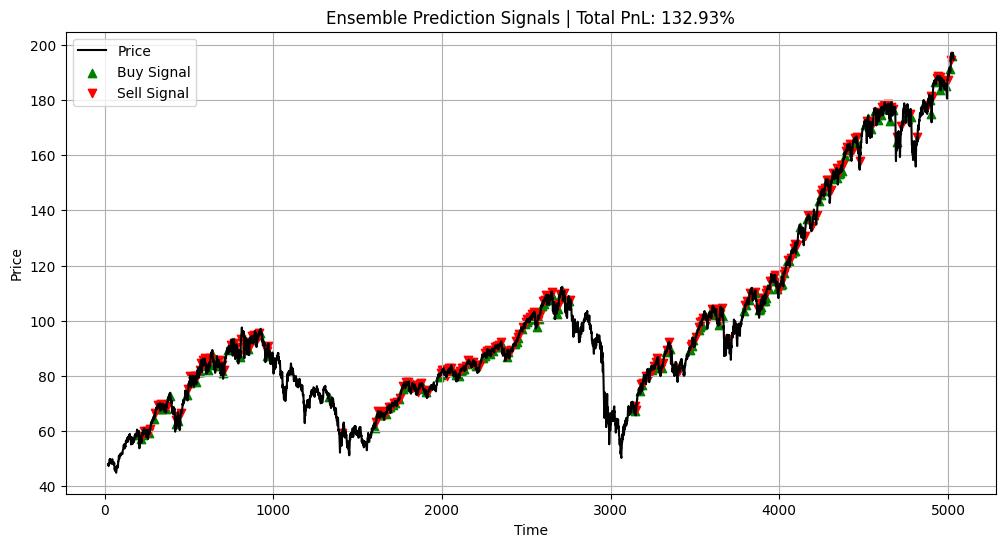

In [15]:
# ensemble_voting.py

import torch
import pandas as pd
import numpy as np
from models.mlp_model import MLPClassifier_dynamic
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset
from utils import create_labeled_dataset, backtest_strategy, plot_prediction_signals

# Load data
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df, best_chromosome)
window_size = 10

# Prepare CNN inputs
cnn_dataset = CNNRollingDataset(df_labeled, window_size)
X_cnn = torch.stack([sample[0] for sample in cnn_dataset])

# Prepare LSTM inputs
lstm_dataset = LSTMRollingDataset(df_labeled, window_size)
X_lstm = torch.stack([sample[0] for sample in lstm_dataset])

# Prepare MLP inputs
X_mlp = torch.tensor(df_labeled[['RSI', 'Interval', 'Trend']].values.astype('float32'))

# Load models
# CNN
cnn_results = pd.read_csv('data/cnn_tuning_results.csv')
best_cnn = cnn_results.iloc[0]
best_kernel = int(best_cnn['kernel_size'])
best_hidden_channels = int(best_cnn['hidden_channels'])

model_cnn = CNNClassifier(
    input_channels=3,
    window_size=window_size,
    kernel_size=best_kernel,
    hidden_channels=best_hidden_channels
)
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model_cnn.eval()
# LSTM
lstm_results = pd.read_csv('data/lstm_tuning_results.csv')
best_lstm = lstm_results.iloc[0]
best_hidden_size = int(best_lstm['hidden_size'])
best_num_layers = int(best_lstm['num_layers'])

model_lstm = LSTMClassifier(input_size=3, hidden_size=best_hidden_size, num_layers=best_num_layers)
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()

# MLP
best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model_mlp = MLPClassifier_dynamic(hidden_sizes)
model_mlp.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model_mlp.eval()

# Make predictions
with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    _, preds_cnn = torch.max(torch.nn.functional.softmax(outputs_cnn, dim=1), 1)
    predictions_cnn = preds_cnn.numpy()

    outputs_lstm = model_lstm(X_lstm)
    _, preds_lstm = torch.max(torch.nn.functional.softmax(outputs_lstm, dim=1), 1)
    predictions_lstm = preds_lstm.numpy()

    outputs_mlp = model_mlp(X_mlp)
    _, preds_mlp = torch.max(torch.nn.functional.softmax(outputs_mlp, dim=1), 1)
    predictions_mlp = preds_mlp.numpy()

# Align lengths (due to rolling window offsets)
min_len = min(len(predictions_cnn), len(predictions_lstm), len(predictions_mlp))
predictions_cnn = predictions_cnn[-min_len:]
predictions_lstm = predictions_lstm[-min_len:]
predictions_mlp = predictions_mlp[-min_len:]
df_eval = df_labeled.iloc[-min_len:]

# Ensemble voting
ensemble_predictions = []
for p1, p2, p3 in zip(predictions_mlp, predictions_cnn, predictions_lstm):
    votes = [p1, p2, p3]
    majority = max(set(votes), key=votes.count)
    ensemble_predictions.append(majority)

# Backtest
results, portfolio, trade_returns = backtest_strategy(df_eval, ensemble_predictions)

# Print results
print("\n=== Ensemble Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot signals
plot_prediction_signals(df_eval, ensemble_predictions, title="Ensemble Prediction Signals", save_path="plots/ensemble_prediction_signals.png")


In [ ]:
# ensemble_voting_oos.py

import torch
import pandas as pd
from datetime import datetime
from models.mlp_model import MLPClassifier_dynamic
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset
from utils import create_labeled_dataset, backtest_strategy, plot_prediction_signals, download_stock_data, calculate_RSI, calculate_SMA

# Define OOS period
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

# Download OOS data
df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df_oos, best_chromosome)
window_size = 10

# Prepare inputs
cnn_dataset = CNNRollingDataset(df_labeled, window_size)
X_cnn = torch.stack([sample[0] for sample in cnn_dataset])

lstm_dataset = LSTMRollingDataset(df_labeled, window_size)
X_lstm = torch.stack([sample[0] for sample in lstm_dataset])

X_mlp = torch.tensor(df_labeled[['RSI', 'Interval', 'Trend']].values.astype('float32'))

# Load models
cnn_results = pd.read_csv('data/cnn_tuning_results.csv')
best_cnn = cnn_results.iloc[0]
best_kernel = int(best_cnn['kernel_size'])
best_hidden_channels = int(best_cnn['hidden_channels'])

model_cnn = CNNClassifier(
    input_channels=3,
    window_size=window_size,
    kernel_size=best_kernel,
    hidden_channels=best_hidden_channels
)
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model_cnn.eval()

model_lstm = LSTMClassifier(input_size=3)
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()

best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model_mlp = MLPClassifier_dynamic(hidden_sizes)
model_mlp.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model_mlp.eval()

# Make predictions
with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    _, preds_cnn = torch.max(torch.nn.functional.softmax(outputs_cnn, dim=1), 1)
    predictions_cnn = preds_cnn.numpy()

    outputs_lstm = model_lstm(X_lstm)
    _, preds_lstm = torch.max(torch.nn.functional.softmax(outputs_lstm, dim=1), 1)
    predictions_lstm = preds_lstm.numpy()

    outputs_mlp = model_mlp(X_mlp)
    _, preds_mlp = torch.max(torch.nn.functional.softmax(outputs_mlp, dim=1), 1)
    predictions_mlp = preds_mlp.numpy()

# Align lengths
min_len = min(len(predictions_cnn), len(predictions_lstm), len(predictions_mlp))
predictions_cnn = predictions_cnn[-min_len:]
predictions_lstm = predictions_lstm[-min_len:]
predictions_mlp = predictions_mlp[-min_len:]
df_eval = df_labeled.iloc[-min_len:]

# Ensemble majority voting
ensemble_predictions = []
for p1, p2, p3 in zip(predictions_mlp, predictions_cnn, predictions_lstm):
    votes = [p1, p2, p3]
    majority = max(set(votes), key=votes.count)
    ensemble_predictions.append(majority)

# Backtest
results, portfolio, trade_returns = backtest_strategy(df_eval, ensemble_predictions)

# Print results
print("\n=== Ensemble OOS Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot signals
plot_prediction_signals(df_eval, ensemble_predictions, title="Ensemble OOS Prediction Signals", save_path="plots/ensemble_oos_prediction_signals.png")


In [16]:
from utils import backtest_strategy_with_position_stoploss

results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
    df_eval,
    ensemble_predictions,
    position_size=0.25,
    stop_loss=0.05,
    take_profit=0.10
)

In [17]:
print("\n=== Backtest with Position Sizing & Stop-Loss/Take-Profit ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

print(f"Number of trades: {len(trade_returns)}")
print(f"Final portfolio value: {portfolio.iloc[-1]:.2f}")


=== Backtest with Position Sizing & Stop-Loss/Take-Profit ===
total_return: 0.4338
annualized_return: 0.0183
sharpe_ratio: 0.6162
max_drawdown: -0.0467
Number of trades: 248
Final portfolio value: 14337.57


In [18]:
results, portfolio, trade_returns = backtest_strategy(df_eval,
    ensemble_predictions)

print("\n=== Backtest ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

print(f"Number of trades: {len(trade_returns)}")
print(f"Final portfolio value: {portfolio.iloc[-1]:.2f}")


=== Backtest ===
total_return: 2.4727
annualized_return: 0.0646
sharpe_ratio: 0.5646
max_drawdown: -0.3181
Number of trades: 219
Final portfolio value: 34727.42


[*********************100%***********************]  1 of 1 completed


Prediction counts: (array([0, 1, 2]), array([675, 712, 705]))

=== Ensemble (Probabilistic Voting) Backtest Performance ===
total_return: 0.1530
annualized_return: 0.0173
sharpe_ratio: 0.4836
max_drawdown: -0.0959
Prediction signal plot saved to plots/ensemble_probabilistic_voting_signals.png


([np.float64(0.012946547023734045),
  np.float64(0.013640479867167196),
  np.float64(0.006341330949335531),
  np.float64(0.0047100730763056774),
  np.float64(-0.030983936846805036),
  np.float64(0.01490336983676193),
  np.float64(-0.014540788963684256),
  np.float64(0.01865644609418053),
  np.float64(-0.0301677381525768),
  np.float64(0.004928241660782368),
  np.float64(0.016771498188079673),
  np.float64(0.01099128516585971),
  np.float64(0.011360077780848833),
  np.float64(-0.004121796510611672),
  np.float64(0.002255242051237308),
  np.float64(0.013085929703214986),
  np.float64(0.016752835069639895),
  np.float64(0.01503004928284199),
  np.float64(0.0035190520627025536),
  np.float64(0.008256129988725502),
  np.float64(0.006347333556786198),
  np.float64(-0.050135555996541445),
  np.float64(0.00517285643921114),
  np.float64(-0.035014617616839536),
  np.float64(0.006305436286265443),
  np.float64(0.0),
  np.float64(0.006752434981427563),
  np.float64(-0.021910974487899457),
  np.fl

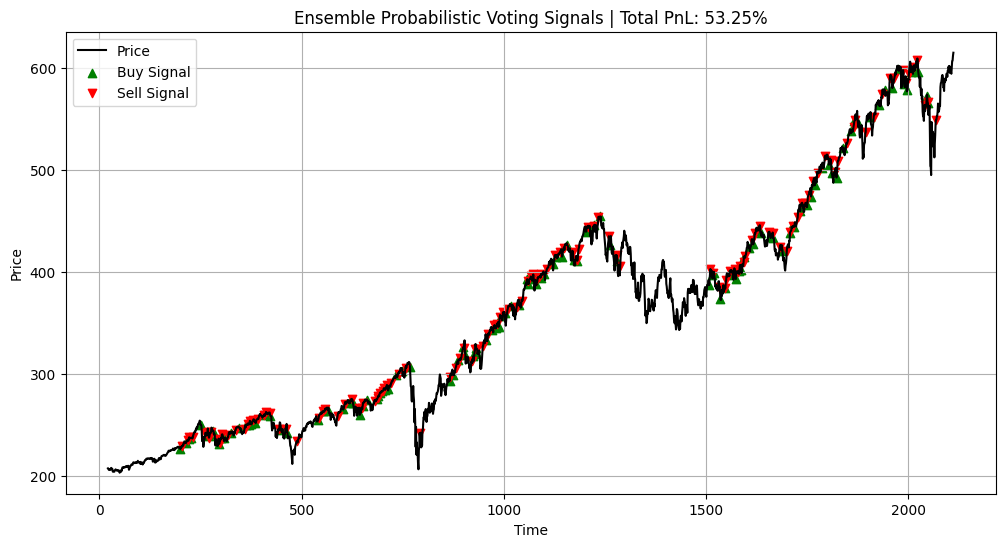

In [20]:
# ensemble_with_cnn_lstm_prob.py

import torch
import pandas as pd
from datetime import datetime
import numpy as np
from models.mlp_model import MLPClassifier_dynamic
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset
from models.transformer_model import TransformerClassifier, TransformerDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, plot_prediction_signals, download_stock_data, calculate_RSI, calculate_SMA

# Load data (true out-of-sample)
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df_oos, best_chromosome)
window_size = 10

# === Generate softmax probabilities for each model ===

# MLP probabilities
X_mlp = torch.tensor(df_labeled[['RSI', 'Interval', 'Trend']].values.astype('float32'))
best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model_mlp = MLPClassifier_dynamic(hidden_sizes)
model_mlp.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model_mlp.eval()
with torch.no_grad():
    outputs_mlp = model_mlp(X_mlp)
    probs_mlp = torch.nn.functional.softmax(outputs_mlp, dim=1).numpy()

# CNN probabilities
cnn_results = pd.read_csv('data/cnn_tuning_results.csv')
best_cnn = cnn_results.iloc[0]
best_kernel = int(best_cnn['kernel_size'])
best_hidden_channels = int(best_cnn['hidden_channels'])

model_cnn = CNNClassifier(
    input_channels=3,
    window_size=window_size,
    kernel_size=best_kernel,
    hidden_channels=best_hidden_channels
)
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model_cnn.eval()
with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    probs_cnn = torch.nn.functional.softmax(outputs_cnn, dim=1).numpy()

# LSTM probabilities
lstm_results = pd.read_csv('data/lstm_tuning_results.csv')
best_lstm = lstm_results.iloc[0]
best_hidden_size = int(best_lstm['hidden_size'])
best_num_layers = int(best_lstm['num_layers'])

model_lstm = LSTMClassifier(input_size=3, hidden_size=best_hidden_size, num_layers=best_num_layers)
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()
with torch.no_grad():
    outputs_lstm = model_lstm(X_lstm)
    probs_lstm = torch.nn.functional.softmax(outputs_lstm, dim=1).numpy()


# === Align probability array lengths ===
min_len = min(len(probs_mlp), len(probs_cnn), len(probs_lstm))
probs_mlp = probs_mlp[-min_len:]
probs_cnn = probs_cnn[-min_len:]
probs_lstm = probs_lstm[-min_len:]
df_eval = df_labeled.iloc[-min_len:]

# === Probabilistic voting ensemble ===
ensemble_predictions = []
for p_mlp, p_cnn, p_lstm in zip(probs_mlp, probs_cnn, probs_lstm):
    all_probs = np.vstack([p_mlp, p_cnn, p_lstm])
    avg_probs = np.mean(all_probs, axis=0)
    final_decision = np.argmax(avg_probs)
    ensemble_predictions.append(final_decision)

print("Prediction counts:", np.unique(ensemble_predictions, return_counts=True))

# === Backtest ensemble ===
results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
    df_eval, ensemble_predictions,
    position_size=0.25, stop_loss=0.03, take_profit=0.10
)

# Print results
print("\n=== Ensemble (Probabilistic Voting) Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot signals
plot_prediction_signals(df_eval, ensemble_predictions, title="Ensemble Probabilistic Voting Signals", save_path="plots/ensemble_probabilistic_voting_signals.png")


In [21]:
import pandas as pd
from datetime import datetime
from utils import create_labeled_dataset, download_stock_data, calculate_RSI, calculate_SMA

# Load or prepare df_eval

# Example: Load your out-of-sample dataset
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_eval = create_labeled_dataset(df_oos, best_chromosome)

# Prepare ensemble_predictions before tuning (import or generate them in the script as in your ensemble module)
# Example placeholder:
ensemble_predictions = [0] * len(df_eval)  # replace with your real predictions


[*********************100%***********************]  1 of 1 completed


In [ ]:
# tune_risk_management.py

import pandas as pd
from utils import backtest_strategy_with_position_stoploss

# Define tuning grid
stop_losses = [0.02, 0.03, 0.05]
take_profits = [0.10, 0.15, 0.20]

# Prepare storage for results
tuning_results = []

# Loop over combinations
for sl in stop_losses:
    for tp in take_profits:
        results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
            df_eval,
            ensemble_predictions,
            position_size=0.25,
            stop_loss=sl,
            take_profit=tp
        )
        tuning_results.append({
            'stop_loss': sl,
            'take_profit': tp,
            'total_return': results['total_return'],
            'annualized_return': results['annualized_return'],
            'sharpe_ratio': results['sharpe_ratio'],
            'max_drawdown': results['max_drawdown'],
            'num_trades': len(trade_returns)
        })

# Convert to DataFrame
tuning_df = pd.DataFrame(tuning_results)

# Sort by Sharpe ratio (or any other metric)
tuning_df.sort_values(by='sharpe_ratio', ascending=False, inplace=True)

# Display results
print("\n=== Risk Management Tuning Results ===")
print(tuning_df.to_string(index=False))

# Optionally save to CSV
tuning_df.to_csv("data/risk_management_tuning_results.csv", index=False)


In [ ]:
# tune_risk_management.py

import torch
import pandas as pd
import numpy as np
from datetime import datetime
from models.mlp_model import MLPClassifier_dynamic
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, download_stock_data, calculate_RSI, calculate_SMA

# === Step 1. Load out-of-sample data ===
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome from GA results
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df_oos, best_chromosome)
window_size = 10

# === Step 2. Generate ensemble predictions ===

# Prepare CNN input
cnn_dataset = CNNRollingDataset(df_labeled, window_size)
X_cnn = torch.stack([sample[0] for sample in cnn_dataset])

# Prepare LSTM input
lstm_dataset = LSTMRollingDataset(df_labeled, window_size)
X_lstm = torch.stack([sample[0] for sample in lstm_dataset])

# Prepare MLP input
X_mlp = torch.tensor(df_labeled[['RSI', 'Interval', 'Trend']].values.astype('float32'))

# Load models
model_cnn = CNNClassifier(input_channels=3, window_size=window_size)
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model_cnn.eval()

model_lstm = LSTMClassifier(input_size=3)
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()

best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model_mlp = MLPClassifier_dynamic(hidden_sizes)
model_mlp.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model_mlp.eval()

# Make predictions
with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    _, preds_cnn = torch.max(torch.nn.functional.softmax(outputs_cnn, dim=1), 1)
    predictions_cnn = preds_cnn.numpy()

    outputs_lstm = model_lstm(X_lstm)
    _, preds_lstm = torch.max(torch.nn.functional.softmax(outputs_lstm, dim=1), 1)
    predictions_lstm = preds_lstm.numpy()

    outputs_mlp = model_mlp(X_mlp)
    _, preds_mlp = torch.max(torch.nn.functional.softmax(outputs_mlp, dim=1), 1)
    predictions_mlp = preds_mlp.numpy()

# Align lengths
min_len = min(len(predictions_cnn), len(predictions_lstm), len(predictions_mlp))
predictions_cnn = predictions_cnn[-min_len:]
predictions_lstm = predictions_lstm[-min_len:]
predictions_mlp = predictions_mlp[-min_len:]
df_eval = df_labeled.iloc[-min_len:]

# Ensemble majority voting
ensemble_predictions = []
for p1, p2, p3 in zip(predictions_mlp, predictions_cnn, predictions_lstm):
    votes = [p1, p2, p3]
    majority = max(set(votes), key=votes.count)
    ensemble_predictions.append(majority)

print("Prediction counts:", np.unique(ensemble_predictions, return_counts=True))

# === Step 3. Tune stop-loss and take-profit ===

# Define tuning grid
stop_losses = [0.02, 0.03, 0.05]
take_profits = [0.10, 0.15, 0.20]

# Prepare storage for results
tuning_results = []

# Loop over combinations
for sl in stop_losses:
    for tp in take_profits:
        results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
            df_eval,
            ensemble_predictions,
            position_size=0.25,
            stop_loss=sl,
            take_profit=tp
        )
        tuning_results.append({
            'stop_loss': sl,
            'take_profit': tp,
            'total_return': results['total_return'],
            'annualized_return': results['annualized_return'],
            'sharpe_ratio': results['sharpe_ratio'],
            'max_drawdown': results['max_drawdown'],
            'num_trades': len(trade_returns)
        })

# Convert to DataFrame
tuning_df = pd.DataFrame(tuning_results)

# Sort by Sharpe ratio
tuning_df.sort_values(by='sharpe_ratio', ascending=False, inplace=True)

# Display results
print("\n=== Risk Management Tuning Results ===")
print(tuning_df.to_string(index=False))

# Optionally save
tuning_df.to_csv("data/risk_management_tuning_results.csv", index=False)


In [ ]:
# tune_risk_management.py

import torch
import pandas as pd
import numpy as np
from datetime import datetime
from models.mlp_model import MLPClassifier_dynamic
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, download_stock_data, calculate_RSI, calculate_SMA

# === Step 1. Load out-of-sample data ===
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df_oos, best_chromosome)
window_size = 10

# === Step 2. Generate ensemble predictions ===

# Prepare CNN input
cnn_dataset = CNNRollingDataset(df_labeled, window_size)
X_cnn = torch.stack([sample[0] for sample in cnn_dataset])

# Prepare LSTM input
lstm_dataset = LSTMRollingDataset(df_labeled, window_size)
X_lstm = torch.stack([sample[0] for sample in lstm_dataset])

# Prepare MLP input
X_mlp = torch.tensor(df_labeled[['RSI', 'Interval', 'Trend']].values.astype('float32'))

# Load models
model_cnn = CNNClassifier(input_channels=3, window_size=window_size)
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model_cnn.eval()

model_lstm = LSTMClassifier(input_size=3)
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()

best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model_mlp = MLPClassifier_dynamic(hidden_sizes)
model_mlp.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model_mlp.eval()

# Make predictions
with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    _, preds_cnn = torch.max(torch.nn.functional.softmax(outputs_cnn, dim=1), 1)
    predictions_cnn = preds_cnn.numpy()

    outputs_lstm = model_lstm(X_lstm)
    _, preds_lstm = torch.max(torch.nn.functional.softmax(outputs_lstm, dim=1), 1)
    predictions_lstm = preds_lstm.numpy()

    outputs_mlp = model_mlp(X_mlp)
    _, preds_mlp = torch.max(torch.nn.functional.softmax(outputs_mlp, dim=1), 1)
    predictions_mlp = preds_mlp.numpy()

# Align lengths
min_len = min(len(predictions_cnn), len(predictions_lstm), len(predictions_mlp))
predictions_cnn = predictions_cnn[-min_len:]
predictions_lstm = predictions_lstm[-min_len:]
predictions_mlp = predictions_mlp[-min_len:]
df_eval = df_labeled.iloc[-min_len:]

# Ensemble majority voting
ensemble_predictions = []
for p1, p2, p3 in zip(predictions_mlp, predictions_cnn, predictions_lstm):
    votes = [p1, p2, p3]
    majority = max(set(votes), key=votes.count)
    ensemble_predictions.append(majority)

print("Prediction counts:", np.unique(ensemble_predictions, return_counts=True))

# === Step 3. Tune stop-loss and take-profit ===

# Define expanded tuning grid
stop_losses = [0.02, 0.03, 0.05, 0.10]
take_profits = [0.10, 0.15, 0.20]

# Prepare storage for results
tuning_results = []

# Baseline (no stop-loss / take-profit)
results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
    df_eval,
    ensemble_predictions,
    position_size=0.25,
    stop_loss=1.0,    # effectively no SL
    take_profit=10.0  # effectively no TP
)
tuning_results.append({
    'stop_loss': 'None',
    'take_profit': 'None',
    'total_return': results['total_return'],
    'annualized_return': results['annualized_return'],
    'sharpe_ratio': results['sharpe_ratio'],
    'max_drawdown': results['max_drawdown'],
    'num_trades': len(trade_returns)
})

# Grid tuning
for sl in stop_losses:
    for tp in take_profits:
        results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
            df_eval,
            ensemble_predictions,
            position_size=0.25,
            stop_loss=sl,
            take_profit=tp
        )
        tuning_results.append({
            'stop_loss': sl,
            'take_profit': tp,
            'total_return': results['total_return'],
            'annualized_return': results['annualized_return'],
            'sharpe_ratio': results['sharpe_ratio'],
            'max_drawdown': results['max_drawdown'],
            'num_trades': len(trade_returns)
        })

# Convert to DataFrame
tuning_df = pd.DataFrame(tuning_results)

# Sort by Sharpe ratio
tuning_df.sort_values(by='sharpe_ratio', ascending=False, inplace=True)

# Display results
print("\n=== Risk Management Tuning Results ===")
print(tuning_df.to_string(index=False))

# Save results
tuning_df.to_csv("data/risk_management_tuning_results.csv", index=False)


In [22]:
from models.transformer_model import train_transformer_model
import pandas as pd
from utils import create_labeled_dataset

# Load your data
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')

# Prepare labeled dataset
# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_eval = create_labeled_dataset(df_oos, best_chromosome)

# Train Transformer
transformer_model = train_transformer_model(df_labeled, window_size=10, epochs=100, batch_size=64, lr=0.001, model_save_path="optimized_models/trained_transformer_window10.pth")


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/100], Loss: 1.1482
Epoch [20/100], Loss: 0.6508
Epoch [40/100], Loss: 0.6024
Epoch [60/100], Loss: 0.5812
Epoch [80/100], Loss: 0.5704
Epoch [100/100], Loss: 0.5417

Transformer model saved as optimized_models/trained_transformer_window10.pth


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



=== Transformer Backtest Performance ===
total_return: 0.4768
annualized_return: 0.0198
sharpe_ratio: 0.6364
max_drawdown: -0.0473
Prediction signal plot saved to plots/transformer_prediction_signals.png


([np.float64(-0.02427802156172044),
  np.float64(0.02570193098377204),
  np.float64(0.007752537543047263),
  np.float64(-0.0011407039695526147),
  np.float64(0.01911282524113261),
  np.float64(0.01524428017719115),
  np.float64(0.005680682894493179),
  np.float64(-0.0008941705439913573),
  np.float64(0.03520866217365999),
  np.float64(0.00663933450612183),
  np.float64(0.0227085119146794),
  np.float64(0.017563414245702125),
  np.float64(-0.011083853658291976),
  np.float64(0.02114904853118365),
  np.float64(-0.02458350304774474),
  np.float64(-0.0042663999714446935),
  np.float64(0.03270385219745079),
  np.float64(0.017448394200533367),
  np.float64(0.017976722710509548),
  np.float64(-0.06062205359064563),
  np.float64(-0.06636215481184221),
  np.float64(0.02111973640117301),
  np.float64(0.06357455740673595),
  np.float64(0.06451338962004644),
  np.float64(0.02838331891721476),
  np.float64(0.027414145952052944),
  np.float64(-0.016924705281493587),
  np.float64(0.03894768934642097)

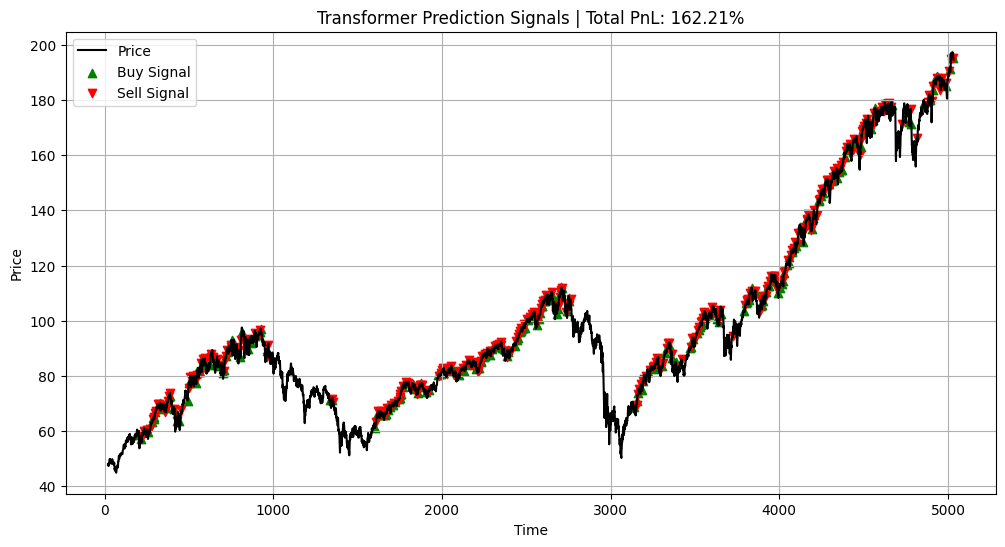

In [23]:
# test_transformer.py

import torch
import pandas as pd
from models.transformer_model import TransformerClassifier, TransformerDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, plot_prediction_signals

# Load data
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df, best_chromosome)
window_size = 10

# Prepare dataset
dataset = TransformerDataset(df_labeled, window_size)
X_test = torch.stack([sample[0] for sample in dataset])
y_true = [sample[1].item() for sample in dataset]

# Load trained model
model = TransformerClassifier(input_size=3, window_size=window_size)
model.load_state_dict(torch.load('optimized_models/trained_transformer_window10.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
    predictions = predicted.numpy()

# Backtest using risk-managed strategy
results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
    df_labeled.iloc[window_size:], predictions,
    position_size=0.25, stop_loss=0.03, take_profit=0.10
)

# Print results
print("\n=== Transformer Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot prediction signals
plot_prediction_signals(df_labeled.iloc[window_size:], predictions, title="Transformer Prediction Signals", save_path="plots/transformer_prediction_signals.png")


In [24]:
# tune_transformer.py

import torch
import pandas as pd
from datetime import datetime
from models.transformer_model import TransformerClassifier, TransformerDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss

# Load data
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df, best_chromosome)
window_size = 10

# Define tuning grid
#dim_models = [32, 64, 128]
#num_heads_list = [2, 4, 8]
#num_layers_list = [1, 2, 3]
#learning_rates = [0.001, 0.0005]
#batch_sizes = [32, 64]

dim_models = [64, 128]
num_heads_list = [4, 8]
num_layers_list = [1, 2]
learning_rates = [0.001]
batch_sizes = [64]
epochs = 5


# Prepare results storage
tuning_results = []

# Loop over grid combinations
for dim_model in dim_models:
    for num_heads in num_heads_list:
        for num_layers in num_layers_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    print(f"\nTraining Transformer: dim_model={dim_model}, num_heads={num_heads}, num_layers={num_layers}, lr={lr}, batch_size={batch_size}")

                    # Prepare dataset and dataloader
                    dataset = TransformerDataset(df_labeled, window_size)
                    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

                    # Initialize model
                    model = TransformerClassifier(
                        input_size=3,
                        window_size=window_size,
                        num_classes=3,
                        dim_model=dim_model,
                        num_heads=num_heads,
                        num_layers=num_layers
                    )
                    criterion = torch.nn.CrossEntropyLoss()
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    # Train model
                    epochs = 30
                    model.train()
                    for epoch in range(epochs):
                        total_loss = 0
                        for X_batch, y_batch in dataloader:
                            optimizer.zero_grad()
                            outputs = model(X_batch)
                            loss = criterion(outputs, y_batch)
                            loss.backward()
                            optimizer.step()
                            total_loss += loss.item()
                        if (epoch + 1) % 10 == 0 or epoch == 0:
                            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

                    # Evaluate model on full dataset
                    model.eval()
                    X_test = torch.stack([sample[0] for sample in dataset])
                    with torch.no_grad():
                        outputs = model(X_test)
                        _, predicted = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
                        predictions = predicted.numpy()

                    # Backtest with risk management
                    results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
                        df_labeled.iloc[window_size:], predictions,
                        position_size=0.25, stop_loss=0.03, take_profit=0.10
                    )

                    # Store results
                    tuning_results.append({
                        'dim_model': dim_model,
                        'num_heads': num_heads,
                        'num_layers': num_layers,
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'total_return': results['total_return'],
                        'annualized_return': results['annualized_return'],
                        'sharpe_ratio': results['sharpe_ratio'],
                        'max_drawdown': results['max_drawdown'],
                        'num_trades': len(trade_returns)
                    })

# Convert to DataFrame
tuning_df = pd.DataFrame(tuning_results)

# Sort by Sharpe ratio
tuning_df.sort_values(by='sharpe_ratio', ascending=False, inplace=True)

# Display results
print("\n=== Transformer Tuning Results ===")
print(tuning_df.to_string(index=False))

# Save results
tuning_df.to_csv("data/transformer_tuning_results.csv", index=False)



Training Transformer: dim_model=64, num_heads=4, num_layers=1, lr=0.001, batch_size=64


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 0.9351
Epoch [10/30], Loss: 0.6457
Epoch [20/30], Loss: 0.5805
Epoch [30/30], Loss: 0.5584

Training Transformer: dim_model=64, num_heads=4, num_layers=2, lr=0.001, batch_size=64


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 0.9662
Epoch [10/30], Loss: 0.6082
Epoch [20/30], Loss: 0.5907
Epoch [30/30], Loss: 0.5691

Training Transformer: dim_model=64, num_heads=8, num_layers=1, lr=0.001, batch_size=64


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 0.9426
Epoch [10/30], Loss: 0.6345
Epoch [20/30], Loss: 0.5913
Epoch [30/30], Loss: 0.5589

Training Transformer: dim_model=64, num_heads=8, num_layers=2, lr=0.001, batch_size=64


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 0.9743
Epoch [10/30], Loss: 0.5956
Epoch [20/30], Loss: 0.5785
Epoch [30/30], Loss: 0.5597

Training Transformer: dim_model=128, num_heads=4, num_layers=1, lr=0.001, batch_size=64


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 0.9581
Epoch [10/30], Loss: 0.6694
Epoch [20/30], Loss: 0.5840
Epoch [30/30], Loss: 0.5690

Training Transformer: dim_model=128, num_heads=4, num_layers=2, lr=0.001, batch_size=64


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 0.9890
Epoch [10/30], Loss: 0.6155
Epoch [20/30], Loss: 0.5998
Epoch [30/30], Loss: 0.5767

Training Transformer: dim_model=128, num_heads=8, num_layers=1, lr=0.001, batch_size=64


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 0.9577
Epoch [10/30], Loss: 0.6549
Epoch [20/30], Loss: 0.6244
Epoch [30/30], Loss: 0.5624

Training Transformer: dim_model=128, num_heads=8, num_layers=2, lr=0.001, batch_size=64


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 0.9829
Epoch [10/30], Loss: 0.6042
Epoch [20/30], Loss: 0.5883
Epoch [30/30], Loss: 0.5987

=== Transformer Tuning Results ===
 dim_model  num_heads  num_layers  learning_rate  batch_size  total_return  annualized_return  sharpe_ratio  max_drawdown  num_trades
       128          4           1          0.001          64      0.490687           0.020272      0.717403     -0.047325         401
        64          8           1          0.001          64      0.487027           0.020146      0.714574     -0.045333         336
        64          8           2          0.001          64      0.490756           0.020274      0.698139     -0.050470         300
        64          4           1          0.001          64      0.434341           0.018298      0.674661     -0.044890         280
       128          8           1          0.001          64      0.426688           0.018024      0.609928     -0.046284         349
        64          4           2          0.001 

In [28]:
l = pd.read_csv('data/transformer_tuning_results.csv')

print(l.iloc[0])

dim_model            128.000000
num_heads              4.000000
num_layers             1.000000
learning_rate          0.001000
batch_size            64.000000
total_return           0.490687
annualized_return      0.020272
sharpe_ratio           0.717403
max_drawdown          -0.047325
num_trades           401.000000
Name: 0, dtype: float64


In [30]:
from models.transformer_model import TransformerClassifier, TransformerDataset
import torch
from torch.utils.data import DataLoader

# Prepare dataset
dataset = TransformerDataset(df_labeled, window_size=10)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize best model configuration
best_params = pd.read_csv('data/transformer_tuning_results.csv')
model = TransformerClassifier(
    input_size=3,
    window_size=10,
    num_classes=3,
    dim_model=int(best_params.iloc[0]['dim_model']),
    num_heads=int(best_params.iloc[0]['num_heads']),
    num_layers=int(best_params.iloc[0]['num_layers'])
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train for 200 epochs
epochs = 200
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

# Save model
torch.save(model.state_dict(), "optimized_models/trained_transformer_best_config.pth")
print("\nTransformer retrained and saved as trained_transformer_best_config.pth")


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/200], Loss: 0.9606
Epoch [20/200], Loss: 0.6133
Epoch [40/200], Loss: 0.5656
Epoch [60/200], Loss: 0.5547
Epoch [80/200], Loss: 0.5411
Epoch [100/200], Loss: 0.5227
Epoch [120/200], Loss: 0.5099
Epoch [140/200], Loss: 0.5017
Epoch [160/200], Loss: 0.4868
Epoch [180/200], Loss: 0.4639
Epoch [200/200], Loss: 0.4261

Transformer retrained and saved as trained_transformer_best_config.pth


/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



=== Transformer Final Backtest Performance ===
total_return: 0.4022
annualized_return: 0.0171
sharpe_ratio: 0.5930
max_drawdown: -0.0493
Prediction signal plot saved to plots/transformer_final_prediction_signals.png


([np.float64(-0.055774560392896105),
  np.float64(0.021045204434624383),
  np.float64(-0.003810908833177417),
  np.float64(0.01962082718138208),
  np.float64(0.02254907944705658),
  np.float64(-0.02961494219320267),
  np.float64(0.01752605542350783),
  np.float64(0.014577745376539566),
  np.float64(0.024772629389473534),
  np.float64(0.01524428017719115),
  np.float64(0.01815970025266537),
  np.float64(0.03520866217365999),
  np.float64(0.022532935081851543),
  np.float64(0.017563414245702125),
  np.float64(-0.017456603492214583),
  np.float64(0.03305428769745283),
  np.float64(0.02114904853118365),
  np.float64(0.007858769390892096),
  np.float64(0.004600906510724112),
  np.float64(-0.06813336584592021),
  np.float64(-0.059360275755211515),
  np.float64(0.06598939235238338),
  np.float64(0.021744884699764322),
  np.float64(0.01965439125001542),
  np.float64(0.013603640780262835),
  np.float64(0.035986303848348555),
  np.float64(-0.004306559304573346),
  np.float64(0.023220368175551488

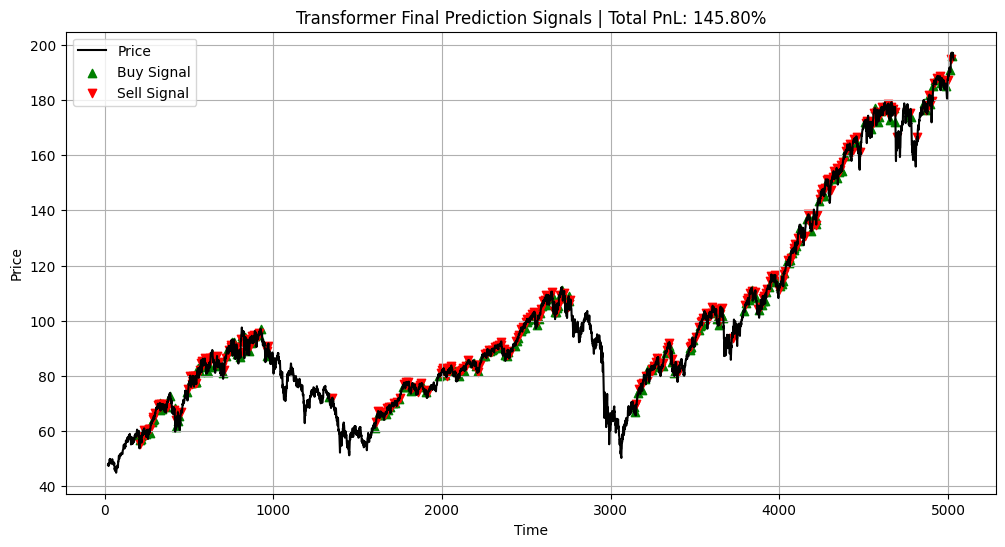

In [32]:
from models.transformer_model import TransformerClassifier, TransformerDataset
import torch
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, plot_prediction_signals
import pandas as pd

# Load data
df = pd.read_csv(f'data/{ticker}_technical_indicators.csv')

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df, best_chromosome)
window_size = 10

# Prepare dataset
dataset = TransformerDataset(df_labeled, window_size)
X_test = torch.stack([sample[0] for sample in dataset])

# Load trained model
model = TransformerClassifier(
    input_size=3,
    window_size=window_size,
    num_classes=3,
    dim_model=int(best_params.iloc[0]['dim_model']),
    num_heads=int(best_params.iloc[0]['num_heads']),
    num_layers=int(best_params.iloc[0]['num_layers'])
)
model.load_state_dict(torch.load('optimized_models/trained_transformer_best_config.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
    predictions = predicted.numpy()

# Backtest with risk management
results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
    df_labeled.iloc[window_size:], predictions,
    position_size=0.25, stop_loss=0.03, take_profit=0.10
)

# Print results
print("\n=== Transformer Final Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot
plot_prediction_signals(df_labeled.iloc[window_size:], predictions, title="Transformer Final Prediction Signals", save_path="plots/transformer_final_prediction_signals.png")


[*********************100%***********************]  1 of 1 completed
/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



=== Transformer True OOS Backtest Performance ===
total_return: 0.1195
annualized_return: 0.0137
sharpe_ratio: 0.3931
max_drawdown: -0.0936
Prediction signal plot saved to plots/transformer_oos_prediction_signals.png


([np.float64(0.012946547023734045),
  np.float64(0.011662342054059277),
  np.float64(0.006341330949335531),
  np.float64(-0.0002619234095348216),
  np.float64(0.0025452739780494325),
  np.float64(0.0063252973903535166),
  np.float64(-0.03070011377937198),
  np.float64(-0.025517791191448515),
  np.float64(0.03638309488723924),
  np.float64(-0.052814098745896036),
  np.float64(0.01590032049400226),
  np.float64(0.020291817620120504),
  np.float64(0.0030223439531539527),
  np.float64(0.022600667589185323),
  np.float64(-0.0012755563535759898),
  np.float64(-0.004121796510611672),
  np.float64(-0.003771552214277583),
  np.float64(0.013085929703214986),
  np.float64(0.016752835069639895),
  np.float64(0.012654698836777981),
  np.float64(-0.0005936164444851354),
  np.float64(0.00048363175330098376),
  np.float64(0.006400479531734713),
  np.float64(0.009178386571287915),
  np.float64(-0.0029925291820618663),
  np.float64(0.0035430233098431557),
  np.float64(-0.050135555996541445),
  np.float6

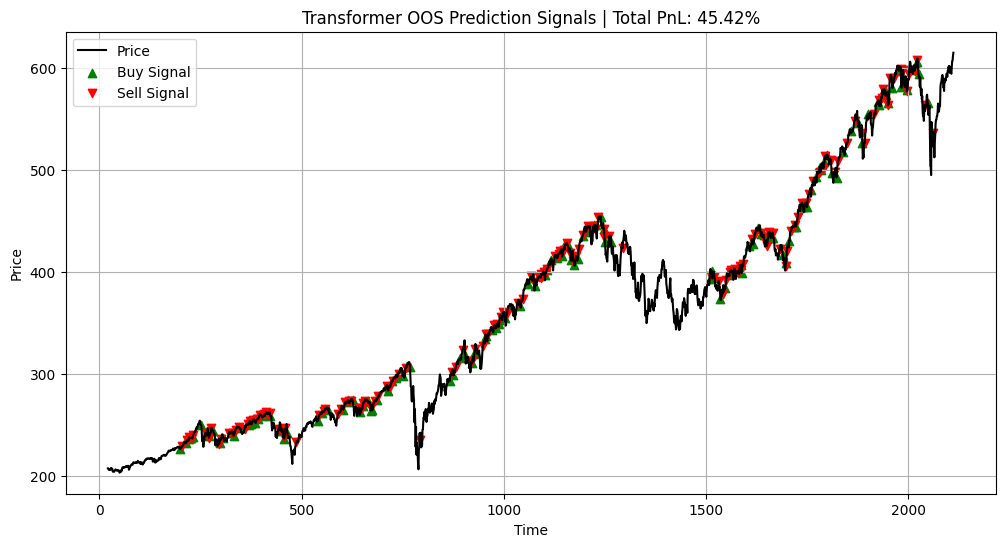

In [34]:
# test_transformer_oos.py

import torch
import pandas as pd
from datetime import datetime

from models.transformer_model import TransformerClassifier, TransformerDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, plot_prediction_signals, download_stock_data, calculate_RSI, calculate_SMA

# Define out-of-sample period
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

# Download OOS data
df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df_oos, best_chromosome)
window_size = 10

# Prepare TransformerDataset
dataset = TransformerDataset(df_labeled, window_size)
X_test = torch.stack([sample[0] for sample in dataset])

# Load trained Transformer model
model = TransformerClassifier(
    input_size=3,
    window_size=window_size,
    num_classes=3,
    dim_model=int(best_params.iloc[0]['dim_model']),
    num_heads=int(best_params.iloc[0]['num_heads']),
    num_layers=int(best_params.iloc[0]['num_layers'])
)
model.load_state_dict(torch.load('optimized_models/trained_transformer_best_config.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
    predictions = predicted.numpy()

# Backtest with risk management
results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
    df_labeled.iloc[window_size:], predictions,
    position_size=0.25, stop_loss=0.03, take_profit=0.10
)

# Print results
print("\n=== Transformer True OOS Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot signals
plot_prediction_signals(df_labeled.iloc[window_size:], predictions, title="Transformer OOS Prediction Signals", save_path="plots/transformer_oos_prediction_signals.png")


[*********************100%***********************]  1 of 1 completed
/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Prediction counts: (array([0, 1, 2]), array([662, 689, 741]))

=== Ensemble (MLP+CNN+LSTM+Transformer) Backtest Performance ===
total_return: 0.1307
annualized_return: 0.0149
sharpe_ratio: 0.4133
max_drawdown: -0.0936
Prediction signal plot saved to plots/ensemble_transformer_prediction_signals.png


([np.float64(0.012946547023734045),
  np.float64(0.011854547765411871),
  np.float64(0.006341330949335531),
  np.float64(0.0025452739780494325),
  np.float64(0.0063252973903535166),
  np.float64(-0.030983936846805036),
  np.float64(-0.011138971664002984),
  np.float64(0.01865644609418053),
  np.float64(-0.03300483502765259),
  np.float64(0.0013130604456774954),
  np.float64(0.0030223439531539527),
  np.float64(0.022600667589185323),
  np.float64(-0.004121796510611672),
  np.float64(-0.003771552214277583),
  np.float64(0.013085929703214986),
  np.float64(0.016752835069639895),
  np.float64(0.014427510753941138),
  np.float64(0.0036916168900853804),
  np.float64(0.009178386571287915),
  np.float64(0.006347333556786198),
  np.float64(-0.050135555996541445),
  np.float64(0.009262646902860524),
  np.float64(-0.03464165474026006),
  np.float64(0.022099044010818168),
  np.float64(0.006132138630216695),
  np.float64(-0.007516341885474385),
  np.float64(-0.012123041184699522),
  np.float64(0.02

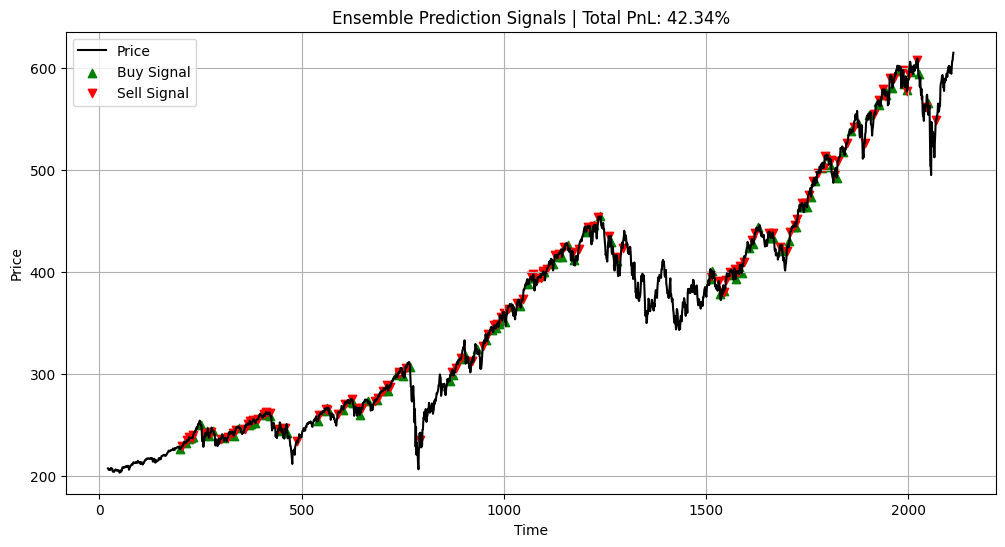

In [38]:
# ensemble_with_transformer.py

import torch
import pandas as pd
from datetime import datetime
import numpy as np
from models.mlp_model import MLPClassifier_dynamic
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset
from models.transformer_model import TransformerClassifier, TransformerDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, plot_prediction_signals, download_stock_data, calculate_RSI, calculate_SMA, weighted_ensemble_vote

# Load data (true out-of-sample)
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df_oos, best_chromosome)
window_size = 10

# === Generate predictions for each model ===

# MLP predictions
X_mlp = torch.tensor(df_labeled[['RSI', 'Interval', 'Trend']].values.astype('float32'))
best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model_mlp = MLPClassifier_dynamic(hidden_sizes)
model_mlp.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model_mlp.eval()
with torch.no_grad():
    outputs_mlp = model_mlp(X_mlp)
    _, preds_mlp = torch.max(torch.nn.functional.softmax(outputs_mlp, dim=1), 1)
    predictions_mlp = preds_mlp.numpy()

# CNN predictions
cnn_results = pd.read_csv('data/cnn_tuning_results.csv')
best_cnn = cnn_results.iloc[0]
best_kernel = int(best_cnn['kernel_size'])
best_hidden_channels = int(best_cnn['hidden_channels'])

model_cnn = CNNClassifier(
    input_channels=3,
    window_size=window_size,
    kernel_size=best_kernel,
    hidden_channels=best_hidden_channels
)
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))

with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    _, preds_cnn = torch.max(torch.nn.functional.softmax(outputs_cnn, dim=1), 1)
    predictions_cnn = preds_cnn.numpy()

# LSTM predictions
lstm_results = pd.read_csv('data/lstm_tuning_results.csv')
best_lstm = lstm_results.iloc[0]
best_hidden_size = int(best_lstm['hidden_size'])
best_num_layers = int(best_lstm['num_layers'])

model_lstm = LSTMClassifier(input_size=3, hidden_size=best_hidden_size, num_layers=best_num_layers)
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()
with torch.no_grad():
    outputs_lstm = model_lstm(X_lstm)
    _, preds_lstm = torch.max(torch.nn.functional.softmax(outputs_lstm, dim=1), 1)
    predictions_lstm = preds_lstm.numpy()

# Transformer predictions
transformer_results = pd.read_csv('data/transformer_tuning_results.csv')
best_transformer = transformer_results.iloc[0]
best_dim_model = int(best_transformer['dim_model'])
best_num_heads = int(best_transformer['num_heads'])
best_num_layers = int(best_transformer['num_layers'])

model_transformer = TransformerClassifier(
    input_size=3,
    window_size=window_size,
    dim_model=best_dim_model,
    num_heads=best_num_heads,
    num_layers=best_num_layers
)
model_transformer.load_state_dict(torch.load('optimized_models/trained_transformer_best_config.pth'))
model_transformer.eval()
with torch.no_grad():
    outputs_transformer = model_transformer(X_transformer)
    _, preds_transformer = torch.max(torch.nn.functional.softmax(outputs_transformer, dim=1), 1)
    predictions_transformer = preds_transformer.numpy()

# === Align prediction lengths ===
min_len = min(len(predictions_mlp), len(predictions_cnn), len(predictions_lstm), len(predictions_transformer))
predictions_mlp = predictions_mlp[-min_len:]
predictions_cnn = predictions_cnn[-min_len:]
predictions_lstm = predictions_lstm[-min_len:]
predictions_transformer = predictions_transformer[-min_len:]
df_eval = df_labeled.iloc[-min_len:]

# === Ensemble majority voting ===

weights = [0.30, 0.20, 0.20, 0.20] 

ensemble_predictions = []
for p1, p2, p3, p4 in zip(predictions_mlp, predictions_cnn, predictions_lstm, predictions_transformer):
    votes = [p1, p2, p3, p4]
    final_decision = weighted_ensemble_vote(votes, weights)
    ensemble_predictions.append(final_decision)

print("Prediction counts:", np.unique(ensemble_predictions, return_counts=True))

# === Backtest ensemble ===
results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
    df_eval, ensemble_predictions,
    position_size=0.25, stop_loss=0.03, take_profit=0.10
)

# Print results
print("\n=== Ensemble (MLP+CNN+LSTM+Transformer) Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot signals
plot_prediction_signals(df_eval, ensemble_predictions, title="Ensemble Prediction Signals", save_path="plots/ensemble_transformer_prediction_signals.png")


In [39]:
import pandas as pd
from datetime import datetime

from utils import create_labeled_dataset, download_stock_data, calculate_RSI, calculate_SMA

# Load true out-of-sample data
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_eval = create_labeled_dataset(df_oos, best_chromosome)


[*********************100%***********************]  1 of 1 completed


In [40]:
from utils import backtest_strategy

results, portfolio, trade_returns = backtest_strategy(
    df_eval, ensemble_predictions,
)

print("\n=== Backtest ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")



=== Backtest ===
total_return: 0.5267
annualized_return: 0.0523
sharpe_ratio: 0.4730
max_drawdown: -0.3408


In [41]:
print("Prediction counts:", np.unique(ensemble_predictions, return_counts=True))


Prediction counts: (array([0, 1, 2]), array([662, 689, 741]))


Confusion matrix saved to plots/ensemble_confusion_matrix.png


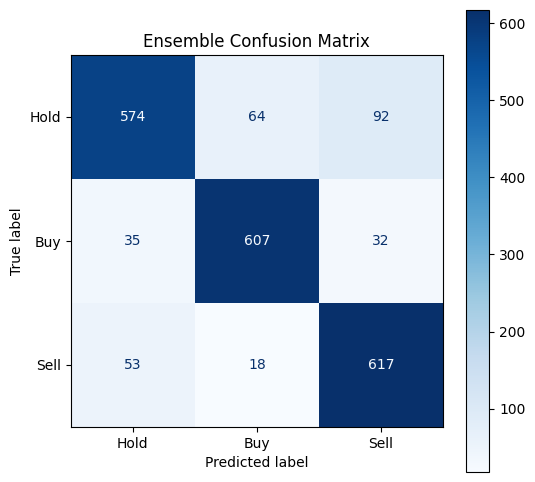

In [42]:
# Assuming you have your true labels and ensemble predictions
y_true = df_eval['Label'].iloc[-len(ensemble_predictions):]
y_pred = ensemble_predictions

plot_confusion_matrix(
    y_true,
    y_pred,
    classes=["Hold", "Buy", "Sell"],
    title="Ensemble Confusion Matrix",
    save_path="plots/ensemble_confusion_matrix.png"
)

In [43]:
from utils import backtest_strategy_with_dynamic_position

results, portfolio, trade_returns = backtest_strategy_with_dynamic_position(
    df_eval, ensemble_predictions,
    stop_loss=0.03, take_profit=0.10, vol_window=20, base_risk=0.01, max_pos_size=0.5
)

print("\n=== Dynamic Position Sizing Backtest ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")



=== Dynamic Position Sizing Backtest ===
total_return: 0.2613
annualized_return: 0.0284
sharpe_ratio: 0.5929
max_drawdown: -0.1374


In [44]:
results, portfolio, trade_returns = backtest_strategy_with_kelly_position(
    df_eval, ensemble_predictions,
    stop_loss=0.03, take_profit=0.10
)

print("\n=== Kelly Criterion Position Sizing Backtest ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")



=== Kelly Criterion Position Sizing Backtest ===
total_return: 0.0054
annualized_return: 0.0006
sharpe_ratio: 0.0688
max_drawdown: -0.0297


[*********************100%***********************]  1 of 1 completed
/Users/stefan/VSCode/Chromo_s&p/myenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Prediction counts: (array([0, 1, 2]), array([648, 715, 729]))

=== Ensemble (Probabilistic Voting) Backtest Performance ===
total_return: 0.1554
annualized_return: 0.0175
sharpe_ratio: 0.4852
max_drawdown: -0.0936
Prediction signal plot saved to plots/ensemble_probabilistic_voting_signals.png


([np.float64(0.012946547023734045),
  np.float64(0.013640479867167196),
  np.float64(0.006341330949335531),
  np.float64(0.0025452739780494325),
  np.float64(0.0063252973903535166),
  np.float64(-0.030983936846805036),
  np.float64(-0.011138971664002984),
  np.float64(0.023907702993129727),
  np.float64(-0.031956795087657225),
  np.float64(0.0013130604456774954),
  np.float64(0.0030223439531539527),
  np.float64(0.022600667589185323),
  np.float64(-0.004121796510611672),
  np.float64(0.013085929703214986),
  np.float64(0.016752835069639895),
  np.float64(0.014427510753941138),
  np.float64(0.0035190520627025536),
  np.float64(0.0010654583035142897),
  np.float64(0.006347333556786198),
  np.float64(-0.050135555996541445),
  np.float64(0.0070572874534076575),
  np.float64(-0.03464165474026006),
  np.float64(0.018239465609757265),
  np.float64(0.006752434981427563),
  np.float64(-0.021664723257907137),
  np.float64(0.002256894701300647),
  np.float64(0.019500521746168765),
  np.float64(0.

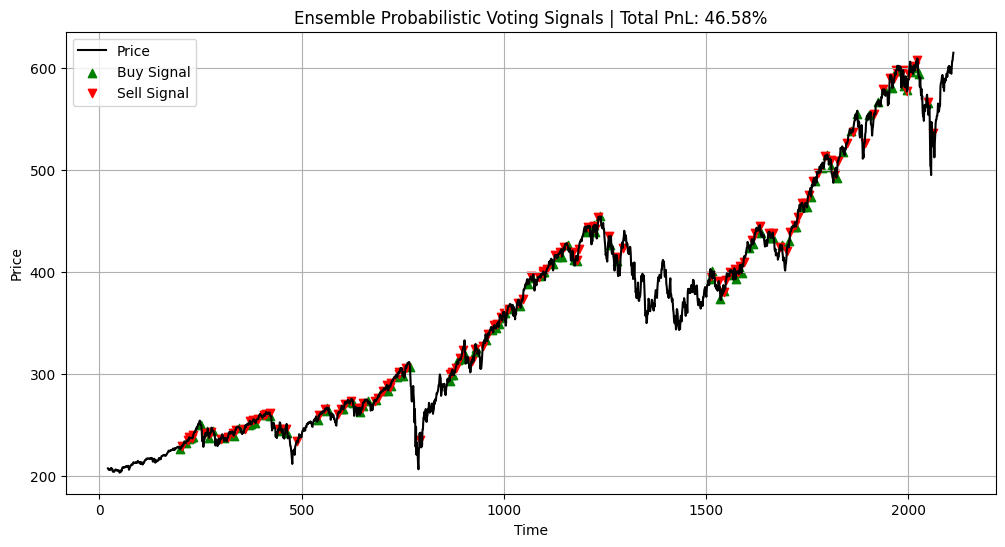

In [49]:
# ensemble_with_transformer.py

import torch
import pandas as pd
from datetime import datetime
import numpy as np
from models.mlp_model import MLPClassifier_dynamic
from models.cnn_model import CNNClassifier, RollingWindowDataset as CNNRollingDataset
from models.lstm_model import LSTMClassifier, RollingWindowDataset as LSTMRollingDataset
from models.transformer_model import TransformerClassifier, TransformerDataset
from utils import create_labeled_dataset, backtest_strategy_with_position_stoploss, plot_prediction_signals, download_stock_data, calculate_RSI, calculate_SMA

# Load data (true out-of-sample)
start_date = "2017-02-01"
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = "SPY"

df_oos = download_stock_data(ticker, start_date, end_date)
df_oos = calculate_RSI(df_oos)
df_oos = calculate_SMA(df_oos)
df_oos['Trend'] = (df_oos['SMA_50'] > df_oos['SMA_200']).astype(int)

# Load best chromosome
ga_results = pd.read_csv('data/GA_final_results.csv')
best_chromosome = ga_results.sort_values('fitness', ascending=False).iloc[0][
    ['down_buy_val', 'down_buy_int', 'down_sell_val', 'down_sell_int',
     'up_buy_val', 'up_buy_int', 'up_sell_val', 'up_sell_int']
].values.tolist()

# Create labeled dataset
df_labeled = create_labeled_dataset(df_oos, best_chromosome)
window_size = 10

# === Generate softmax probabilities for each model ===

# MLP probabilities
X_mlp = torch.tensor(df_labeled[['RSI', 'Interval', 'Trend']].values.astype('float32'))
best_params = pd.read_csv("optimized_models/mlp_tuning_results.csv")
hidden_sizes_str = best_params.loc[0, 'hidden_sizes']
hidden_sizes = ast.literal_eval(str(hidden_sizes_str))
model_mlp = MLPClassifier_dynamic(hidden_sizes)
model_mlp.load_state_dict(torch.load('optimized_models/trained_mlp_final.pth'))
model_mlp.eval()
with torch.no_grad():
    outputs_mlp = model_mlp(X_mlp)
    probs_mlp = torch.nn.functional.softmax(outputs_mlp, dim=1).numpy()

# CNN probabilities
cnn_results = pd.read_csv('data/cnn_tuning_results.csv')
best_cnn = cnn_results.iloc[0]
best_kernel = int(best_cnn['kernel_size'])
best_hidden_channels = int(best_cnn['hidden_channels'])

model_cnn = CNNClassifier(
    input_channels=3,
    window_size=window_size,
    kernel_size=best_kernel,
    hidden_channels=best_hidden_channels
)
model_cnn.load_state_dict(torch.load('optimized_models/trained_cnn_best_tuned.pth'))
model_cnn.eval()
with torch.no_grad():
    outputs_cnn = model_cnn(X_cnn)
    probs_cnn = torch.nn.functional.softmax(outputs_cnn, dim=1).numpy()

# LSTM probabilities
lstm_results = pd.read_csv('data/lstm_tuning_results.csv')
best_lstm = lstm_results.iloc[0]
best_hidden_size = int(best_lstm['hidden_size'])
best_num_layers = int(best_lstm['num_layers'])

model_lstm = LSTMClassifier(
    input_size=3,
    hidden_size=best_hidden_size,
    num_layers=best_num_layers
)
model_lstm.load_state_dict(torch.load('optimized_models/trained_lstm_best_tuned.pth'))
model_lstm.eval()
with torch.no_grad():
    outputs_lstm = model_lstm(X_lstm)
    probs_lstm = torch.nn.functional.softmax(outputs_lstm, dim=1).numpy()

# Transformer probabilities
transformer_results = pd.read_csv('data/transformer_tuning_results.csv')
best_transformer = transformer_results.iloc[0]
best_dim_model = int(best_transformer['dim_model'])
best_num_heads = int(best_transformer['num_heads'])
best_num_layers = int(best_transformer['num_layers'])

model_transformer = TransformerClassifier(
    input_size=3,
    window_size=window_size,
    dim_model=best_dim_model,
    num_heads=best_num_heads,
    num_layers=best_num_layers
)
model_transformer.load_state_dict(torch.load('optimized_models/trained_transformer_best_config.pth'))
model_transformer.eval()
with torch.no_grad():
    transformer_dataset = TransformerDataset(df_labeled, window_size)
    X_transformer = torch.stack([sample[0] for sample in transformer_dataset])
    probs_transformer = torch.nn.functional.softmax(outputs_transformer, dim=1).numpy()

# === Align probability array lengths ===
min_len = min(len(probs_mlp), len(probs_cnn), len(probs_lstm), len(probs_transformer))
probs_mlp = probs_mlp[-min_len:]
probs_cnn = probs_cnn[-min_len:]
probs_lstm = probs_lstm[-min_len:]
probs_transformer = probs_transformer[-min_len:]
df_eval = df_labeled.iloc[-min_len:]

# === Probabilistic voting ensemble ===
ensemble_predictions = []
for p_mlp, p_cnn, p_lstm, p_trans in zip(probs_mlp, probs_cnn, probs_lstm, probs_transformer):
    all_probs = np.vstack([p_mlp, p_cnn, p_lstm, p_trans])
    avg_probs = np.mean(all_probs, axis=0)
    final_decision = np.argmax(avg_probs)
    ensemble_predictions.append(final_decision)

print("Prediction counts:", np.unique(ensemble_predictions, return_counts=True))

# === Backtest ensemble ===
results, portfolio, trade_returns = backtest_strategy_with_position_stoploss(
    df_eval, ensemble_predictions,
    position_size=0.25, stop_loss=0.03, take_profit=0.10
)

# Print results
print("\n=== Ensemble (Probabilistic Voting) Backtest Performance ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot signals
plot_prediction_signals(df_eval, ensemble_predictions, title="Ensemble Probabilistic Voting Signals", save_path="plots/ensemble_probabilistic_voting_signals.png")
